
Ynet, without transformers resnet int the final layers.

masking

raw audio and spectrograms are fed

learnable spectrogram is included to transform raw audio to a spectrgram like representation

output is spectrogram
```
# This is formatted as code
```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install stempeg==0.1.6
!pip install neptune-client
!nvidia-smi
!pip install torchmetrics
!pip install pystoi
!pip install mir_eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.3/509.3 KB 12.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.8/443.8 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 33.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#@title Import
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as T
from torch.autograd import Variable
import joblib
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import librosa.display
import stempeg
import os
import matplotlib.pyplot as plt
from scipy import signal
import neptune.new as neptune
from neptune.new.types import File
from scipy import signal

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.9/dist-packages/neptune/internal/backends/hosted_client.py:48: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
<ipython-input-3-86ccaa165afe>:22: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


In [ ]:
#@title Model 1 relu
class learnable_spectrogram_NN(nn.Module):
    def __init__(self, batch_size, seq_length, timebins, freqbins):
        super(learnable_spectrogram_NN, self).__init__()
        ''' This nn is defined to sequence lengths more than 67072. If we are using less sequence length than that reduce conv 1d layers. The reason is when con1d happens the ones
        with the higher dilation rate may not get the time bin we expected, freqbibn should be more than 5'''
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.kernal_size =  2048
        self.timebins = timebins
        self.freqbins = freqbins

        self.m = nn.BatchNorm1d(1)

        self.c1 = nn.Conv1d(1, int(freqbins/5), self.kernal_size, stride=int(self.kernal_size/4), padding=0, dilation=1)
        self.c2 = nn.Conv1d(1, int(freqbins/5), self.kernal_size,   stride=int((self.seq_length - 2 *(self.kernal_size -1) - 1)/self.timebins + 1)   , padding=0, dilation=2)
        self.c3 = nn.Conv1d(1, int(freqbins/5), self.kernal_size,   stride=int((self.seq_length - 4 *(self.kernal_size -1) - 1)/self.timebins + 1)   , padding=0, dilation=4)
        self.c4 = nn.Conv1d(1, int(freqbins/5), self.kernal_size,   stride=int((self.seq_length - 8 *(self.kernal_size -1) - 1)/self.timebins + 1)   , padding=0, dilation=8)
        self.c5 = nn.Conv1d(1, freqbins-4*int(freqbins/5), self.kernal_size,   stride=int((self.seq_length - 16*(self.kernal_size -1) - 1)/self.timebins + 1)   , padding=0, dilation=16)



    def forward(self, input):
        input = self.m(input)
        x = torch.cat( ( F.relu(self.c1(input)),F.relu(self.c2(input)),F.relu(self.c3(input)),F.relu(self.c4(input)),F.relu(self.c5(input))  ), dim = 1 )

        return torch.unsqueeze(torch.transpose(x,1,2),1)

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class VITformer(nn.Module):
    def __init__(self, seq_len,batch_size, number_of_head, n_layers):
        super(VITformer, self).__init__()

        self.seq_len = seq_len
        self.number_of_head =  number_of_head

        self.encoder_layer = nn.TransformerEncoderLayer(d_model = seq_len, nhead = number_of_head)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers).to(device)

        self.encoder_layer_2 = nn.TransformerEncoderLayer(d_model = batch_size, nhead = number_of_head)
        self.transformer_encoder_2 = nn.TransformerEncoder(self.encoder_layer_2, num_layers=n_layers).to(device)

    def forward(self, input):
        x = self.transformer_encoder(input)
        x = self.transformer_encoder_2(torch.transpose(x,1,2))
        return torch.transpose(x,1,2)

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
class Sepformer(nn.Module):
    def __init__(self, seq_len,batch_size, number_of_head, n_layers):
        super(Sepformer, self).__init__()

        self.seq_len = seq_len
        self.number_of_head =  number_of_head

        self.b1 = VITformer(seq_len,batch_size,number_of_head, n_layers)
        self.b2 = VITformer(seq_len,batch_size,number_of_head, n_layers)
        self.b3 = VITformer(seq_len,batch_size,number_of_head, n_layers)
        self.b4 = VITformer(seq_len,batch_size,number_of_head, n_layers)
        self.b5 = VITformer(seq_len,batch_size,number_of_head, n_layers)
        self.b6 = VITformer(seq_len,batch_size,number_of_head, n_layers)

    def forward(self, input):
        x = self.b1(input)
        x = self.b2(input)
        x = self.b3(input)
        x = self.b4(input)
        x = self.b5(input)
        x = self.b6(input)

        return x
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class ConvBlock(nn.Module):
    def __init__(self,C,Cout,DilationRate,padding,kernal):
      super(ConvBlock,self).__init__()
      '''
      C - number of channels
      W - Width of Image
      H - Height of Image
      '''

      self.C = C


      self.c1 = nn.Conv2d(C,Cout,kernal,stride = 1, padding= padding, dilation = DilationRate)
      self.c2 = nn.Conv2d(Cout,Cout,kernal,stride = 1, padding= padding, dilation = DilationRate)
      self.p1 = nn.MaxPool2d(kernel_size = (2,2))
      self.d1 = nn.Dropout(p=0.05)
      self.n1 = nn.BatchNorm2d(Cout)


    def forward(self,x):
      #Shrink
      Inp = x.size(dim=2)
      x = F.relu(self.c1(x))
      x = F.relu(self.c2(x))
      skip = x
      x = F.relu(self.p1(x))
      x = F.relu(self.d1(x))
      x = F.relu(self.n1(x))
      return x,skip


#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


#with attention
class TransConvBlock(nn.Module):
    def __init__(self,C,Cout,DilationRate):
      super(TransConvBlock,self).__init__()
      '''
      C - number of input channels
      Cout - Output channels
      '''

      self.C = C


      self.u1 = nn.ConvTranspose2d(C,Cout,2,stride = (2,2), padding= 0)

      self.interConv = nn.Conv2d(2*Cout,1,1,stride = 1,dilation = DilationRate)

      self.c1 = nn.Conv2d(2*Cout,Cout,1,stride = 1,dilation = DilationRate)
      self.c2 = nn.Conv2d(Cout,Cout,1,stride = 1,dilation = DilationRate)
      self.n1 = nn.BatchNorm2d(Cout)


    def forward(self,x,skip,skip2):
      #deconvolute
      x = F.gelu(self.u1(x))

      #skip connection
      start = math.ceil((skip.size(dim=3)-x.size(dim=3))/2)
      end = x.size(dim=3)
      skip = skip[:,:,:,start:start+end]    #max value = 5.1559

      start = math.ceil((skip2.size(dim=3)-x.size(dim=3))/2)
      skip2 = skip2[:,:,:,start:start+end]    #max value = 5.1559

      skip = torch.cat((skip,skip2),1)
      #attention
      Skip_Attention = torch.sigmoid(self.interConv(skip))
      Skip_Attention = torch.squeeze(Skip_Attention)

      Attention1 = VITformer( int(Skip_Attention.size(dim = 2)) , int(Skip_Attention.size(dim = 1)) ,2,2)
      Attention2 = VITformer( int(Skip_Attention.size(dim = 2)) , int(Skip_Attention.size(dim = 1)) ,2,2)

      Skip_Attention = Attention1(Skip_Attention)        #max value = 4.1.. , to make it a weightng function we can apply a softmax on top of it.
      Skip_Attention = Attention2(Skip_Attention)

      skip = skip*torch.unsqueeze(Skip_Attention,1)
      x = torch.cat((skip,x),1)

      x = F.relu(self.c1(x))
      x = F.relu(self.c2(x))
      x = F.relu(self.n1(x))

      return skip
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


#without attention
class DeConvBlock(nn.Module):
    def __init__(self,C,Cout,DilationRate):
      super(DeConvBlock,self).__init__()
      '''
      C - number of input channels
      Cout - Output channels
      '''

      self.C = C


      self.u1 = nn.ConvTranspose2d(C,Cout,2,stride = (2,2), padding= 0)
      self.c1 = nn.Conv2d(3*Cout,Cout,1,stride = 1,dilation = DilationRate)
      self.c2 = nn.Conv2d(Cout,Cout,1,stride = 1,dilation = DilationRate)
      self.n1 = nn.BatchNorm2d(Cout)


    def forward(self,x,skip,skip2):
      #deconvolute
      x = F.relu(self.u1(x))

      start = math.ceil((skip.size(dim=3)-x.size(dim=3))/2)
      end = x.size(dim=3)
      skip = skip[:,:,:,start:start+end]

      start = math.ceil((skip2.size(dim=3)-x.size(dim=3))/2)
      skip2 = skip2[:,:,:,start:start+end]

      x = torch.cat((skip,skip2,x),1)

      x = F.relu(self.c1(x))
      x = F.relu(self.c2(x))
      x = F.relu(self.n1(x))

      return x


#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


class Unet(nn.Module):
    def __init__(self,batch_size,C,seq_length, timebins, freqbins):
      super().__init__()
      '''
      eg :
      input shape = [batch size,1, sequence length] -->raw audio
      output shape = [batch size, 1, timebins, freqbins]
      seq_length = 67072,132608
      timebins = 128,256
      freqbins = 1024
      '''
      self.B = batch_size
      #C,Cout,DilationRate,padding,kernal

      self.spectrogram = learnable_spectrogram_NN(batch_size,seq_length, timebins, freqbins)

                                                                                #input = torch.randn(64,1,128,512)
      self.c1 = ConvBlock(C,16,(1,1),1,3)                                       #x.shape =  torch.Size([64, 16, 64, 256]) skip.shape torch.Size([64, 16, 128, 512])
      self.c2 = ConvBlock(16,32,(1,2),(1,2),3)                                  #x.shape =  torch.Size([64, 32, 32, 128]) skip.shape torch.Size([64, 32, 64, 256])
      self.c3 = ConvBlock(32,64,(1,4),(1,4),3)                                  #x.shape =  torch.Size([64, 64, 16, 64]) skip.shape torch.Size([64, 64, 32, 128])
      self.c4 = ConvBlock(64,128,(1,8),(1,8),3)                                 #x.shape =  torch.Size([64, 128, 8, 32]) skip.shape torch.Size([64, 128, 16, 64])
      self.c5 = ConvBlock(128,256,(1,16),(1,16),3)                              #x.shape =  torch.Size([64, 256, 4, 16]) skip.shape torch.Size([64, 256, 8, 32])

      self.cc1 = ConvBlock(C,16,(1,1),1,3)                                       #x.shape =  torch.Size([64, 16, 64, 256]) skip.shape torch.Size([64, 16, 128, 512])
      self.cc2 = ConvBlock(16,32,(1,2),(1,2),3)                                  #x.shape =  torch.Size([64, 32, 32, 128]) skip.shape torch.Size([64, 32, 64, 256])
      self.cc3 = ConvBlock(32,64,(1,4),(1,4),3)                                  #x.shape =  torch.Size([64, 64, 16, 64]) skip.shape torch.Size([64, 64, 32, 128])
      self.cc4 = ConvBlock(64,128,(1,8),(1,8),3)                                 #x.shape =  torch.Size([64, 128, 8, 32]) skip.shape torch.Size([64, 128, 16, 64])
      self.cc5 = ConvBlock(128,256,(1,16),(1,16),3)                              #x.shape =  torch.Size([64, 256, 4, 16]) skip.shape torch.Size([64, 256, 8, 32])

      self.c5_1 = nn.Conv2d(512,512,1,stride = 1)
      self.c5_2 = nn.Conv2d(512,512,1,stride = 1)
      self.n5 = nn.BatchNorm2d(512)                                             #x.shape =  torch.Size([64, 512, 4, 16])


      self.t1 = DeConvBlock(512,256,(1,16))                                  #x.shape =  torch.Size([64, 256, 8, 32])
      self.t2 = DeConvBlock(256,128,(1,8))                                   #x.shape =  torch.Size([64, 128, 16, 64])
      self.t3 = DeConvBlock(128,64,(1,4))                                    #x.shape =  torch.Size([64, 64, 32, 128])
      self.t4 = DeConvBlock(64,32,(1,2))                                        #x.shape =  torch.Size([64, 32, 64, 256])
      self.t5 = DeConvBlock(32,16,(1,1))                                        #x.shape =  torch.Size([64, 16, 128, 512])

      self.OutConv = nn.Conv2d(16,1,1,stride = 1)                               #x.shape =  torch.Size([64, 2, 128, 512])
      # self.thresh = nn.Threshold(0.5,0)
      # self.loss = nn.BCELoss()
      self.Hardtan = nn.Hardtanh(0,1.4)

    def forward(self,x,x2):
      #raw audio spectrogram like representation
      x = self.spectrogram(x)
      # attention = Sepformer(int(x.size(dim = 3)) , int(x.size(dim = 2)) ,2,2)
      # x = torch.unsqueeze( attention(torch.squeeze(x)), 1)
      #Shrink
      Inp = x
      x,skip_1 = self.c1(x)
      x,skip_2 = self.c2(x)
      x,skip_3 = self.c3(x)
      x,skip_4 = self.c4(x)
      x,skip_5 = self.c5(x)

      Inp2 = x2
      x2,skip2_1 = self.cc1(x2)
      x2,skip2_2 = self.cc2(x2)
      x2,skip2_3 = self.cc3(x2)
      x2,skip2_4 = self.cc4(x2)
      x2,skip2_5 = self.cc5(x2)

      x = torch.cat((x,x2),1)
      x = F.relu( self.n5( self.c5_2( self.c5_1(x) ) ) )

      x =  self.t1(x,skip_5, skip2_5)
      x =  self.t2(x,skip_4, skip2_4)
      x =  self.t3(x,skip_3, skip2_3)
      x =  self.t4(x,skip_2, skip2_2)
      x =  self.t5(x,skip_1, skip2_1)

      x = F.relu(self.OutConv(x))
      # attention = Sepformer(int(x.size(dim = 3)) , int(x.size(dim = 2)) ,2,2)
      # x = torch.unsqueeze( attention(torch.squeeze(x)), 1)
      # x = F.log_softmax(self.OutConv(x),1)

      #activation function mask
      # x = F.relu(Inp*x)

      #learnable score for sharpness
      # score=self.loss( torch.sigmoid( Inp2*self.thresh(torch.sigmoid(x)) ), torch.sigmoid(x))*5  #a parameter to adjust the sharpness of score. if masked input and out put non mask x is too far away from sharpness it will produce a high score. The more it details it will produce a low score
      # x = T.adjust_sharpness(x,int(score.item()))
      # x = T.adjust_sharpness(x,10)

      #threshold
      # x = Inp2*self.thresh(torch.sigmoid(x))

      #hardtanh
      x = Inp2*self.Hardtan(x)


      return Inp,x

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


class SISNR(nn.Module):
  def __init__(self,time_window_size):
    super(SISNR,self).__init__();
    self.time_window_size=time_window_size
    #self.MSErr = nn.mse_loss()
  def forward(self,predictions, target):

    #predictions = Variable(predictions, requires_grad=True)
    #target      = Variable(target, requires_grad=True)
    predictions= torch.reshape(predictions,(-1,1))
    target     = torch.reshape(target,(-1,1))
    starget    = torch.matmul(torch.transpose(predictions,0,1),target)
    starget    = torch.mul(starget,target)
    temp       = torch.matmul(torch.transpose(target,0,1), target)
    starget    = torch.div(starget,temp)
    #enoise     = F.mse_loss(predictions , starget)
    enoise     = torch.sub(predictions , starget)
    starget    = torch.matmul(torch.transpose(starget,0,1), starget)
    enoise     = torch.matmul(torch.transpose(enoise,0,1), enoise)
    loss_value = 10*torch.log10(torch.div(   starget , enoise    ))

    return loss_value #snr ---> signal/noise ,to optimize signal should go higher and noise should go down which makees the loss value go up when optimizing.Since pytorchs backward is made to minimize the loss we use 1/loss_value



In [ ]:
#@title Model 2 leaky relu
class learnable_spectrogram_NN(nn.Module):
    def __init__(self, batch_size, seq_length, timebins, freqbins):
        super(learnable_spectrogram_NN, self).__init__()
        ''' This nn is defined to sequence lengths more than 67072. If we are using less sequence length than that reduce conv 1d layers. The reason is when con1d happens the ones
        with the higher dilation rate may not get the time bin we expected, freqbibn should be more than 5'''
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.kernal_size =  2048
        self.timebins = timebins
        self.freqbins = freqbins

        self.m = nn.BatchNorm1d(1)

        self.c1 = nn.Conv1d(1, int(freqbins/5), self.kernal_size, stride=int(self.kernal_size/4), padding=0, dilation=1)
        self.c2 = nn.Conv1d(1, int(freqbins/5), self.kernal_size,   stride=int((self.seq_length - 2 *(self.kernal_size -1) - 1)/self.timebins + 1)   , padding=0, dilation=2)
        self.c3 = nn.Conv1d(1, int(freqbins/5), self.kernal_size,   stride=int((self.seq_length - 4 *(self.kernal_size -1) - 1)/self.timebins + 1)   , padding=0, dilation=4)
        self.c4 = nn.Conv1d(1, int(freqbins/5), self.kernal_size,   stride=int((self.seq_length - 8 *(self.kernal_size -1) - 1)/self.timebins + 1)   , padding=0, dilation=8)
        self.c5 = nn.Conv1d(1, freqbins-4*int(freqbins/5), self.kernal_size,   stride=int((self.seq_length - 16*(self.kernal_size -1) - 1)/self.timebins + 1)   , padding=0, dilation=16)



    def forward(self, input):
        input = self.m(input)
        x = torch.cat( ( F.leaky_relu(self.c1(input)),F.leaky_relu(self.c2(input)),F.leaky_relu(self.c3(input)),F.leaky_relu(self.c4(input)),F.leaky_relu(self.c5(input))  ), dim = 1 )

        return torch.unsqueeze(torch.transpose(x,1,2),1)

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class VITformer(nn.Module):
    def __init__(self, seq_len,batch_size, number_of_head, n_layers):
        super(VITformer, self).__init__()

        self.seq_len = seq_len
        self.number_of_head =  number_of_head

        self.encoder_layer = nn.TransformerEncoderLayer(d_model = seq_len, nhead = number_of_head)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers).to(device)

        self.encoder_layer_2 = nn.TransformerEncoderLayer(d_model = batch_size, nhead = number_of_head)
        self.transformer_encoder_2 = nn.TransformerEncoder(self.encoder_layer_2, num_layers=n_layers).to(device)

    def forward(self, input):
        x = self.transformer_encoder(input)
        x = self.transformer_encoder_2(torch.transpose(x,1,2))
        return torch.transpose(x,1,2)

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
class Sepformer(nn.Module):
    def __init__(self, seq_len,batch_size, number_of_head, n_layers):
        super(Sepformer, self).__init__()

        self.seq_len = seq_len
        self.number_of_head =  number_of_head

        self.b1 = VITformer(seq_len,batch_size,number_of_head, n_layers)
        self.b2 = VITformer(seq_len,batch_size,number_of_head, n_layers)
        self.b3 = VITformer(seq_len,batch_size,number_of_head, n_layers)
        self.b4 = VITformer(seq_len,batch_size,number_of_head, n_layers)
        self.b5 = VITformer(seq_len,batch_size,number_of_head, n_layers)
        self.b6 = VITformer(seq_len,batch_size,number_of_head, n_layers)

    def forward(self, input):
        x = self.b1(input)
        x = self.b2(input)
        x = self.b3(input)
        x = self.b4(input)
        x = self.b5(input)
        x = self.b6(input)

        return x
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class ConvBlock(nn.Module):
    def __init__(self,C,Cout,DilationRate,padding,kernal):
      super(ConvBlock,self).__init__()
      '''
      C - number of channels
      W - Width of Image
      H - Height of Image
      '''

      self.C = C


      self.c1 = nn.Conv2d(C,Cout,kernal,stride = 1, padding= padding, dilation = DilationRate)
      self.c2 = nn.Conv2d(Cout,Cout,kernal,stride = 1, padding= padding, dilation = DilationRate)
      self.p1 = nn.MaxPool2d(kernel_size = (2,2))
      self.d1 = nn.Dropout(p=0.05)
      self.n1 = nn.BatchNorm2d(Cout)


    def forward(self,x):
      #Shrink
      Inp = x.size(dim=2)
      x = F.relu(self.c1(x))
      x = F.relu(self.c2(x))
      skip = x
      x = F.relu(self.p1(x))
      x = F.relu(self.d1(x))
      x = F.relu(self.n1(x))
      return x,skip

class NConvBlock(nn.Module):
    def __init__(self,C,Cout,DilationRate,padding,kernal):
      super(NConvBlock,self).__init__()
      '''
      C - number of channels
      W - Width of Image
      H - Height of Image
      '''

      self.C = C


      self.c1 = nn.Conv2d(C,Cout,kernal,stride = 1, padding= padding, dilation = DilationRate)
      self.c2 = nn.Conv2d(Cout,Cout,kernal,stride = 1, padding= padding, dilation = DilationRate)
      self.p1 = nn.MaxPool2d(kernel_size = (2,2))
      self.d1 = nn.Dropout(p=0.05)
      self.n1 = nn.BatchNorm2d(Cout)


    def forward(self,x):
      #Shrink
      Inp = x.size(dim=2)
      x = F.leaky_relu(self.c1(x))
      x = F.leaky_relu(self.c2(x))
      skip = x
      x = F.leaky_relu(self.p1(x))
      x = F.leaky_relu(self.d1(x))
      x = F.leaky_relu(self.n1(x))
      return x,skip
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


#with attention
class TransConvBlock(nn.Module):
    def __init__(self,C,Cout,DilationRate):
      super(TransConvBlock,self).__init__()
      '''
      C - number of input channels
      Cout - Output channels
      '''

      self.C = C


      self.u1 = nn.ConvTranspose2d(C,Cout,2,stride = (2,2), padding= 0)

      self.interConv = nn.Conv2d(2*Cout,1,1,stride = 1,dilation = DilationRate)

      self.c1 = nn.Conv2d(2*Cout,Cout,1,stride = 1,dilation = DilationRate)
      self.c2 = nn.Conv2d(Cout,Cout,1,stride = 1,dilation = DilationRate)
      self.n1 = nn.BatchNorm2d(Cout)


    def forward(self,x,skip,skip2):
      #deconvolute
      x = F.gelu(self.u1(x))

      #skip connection
      start = math.ceil((skip.size(dim=3)-x.size(dim=3))/2)
      end = x.size(dim=3)
      skip = skip[:,:,:,start:start+end]    #max value = 5.1559

      start = math.ceil((skip2.size(dim=3)-x.size(dim=3))/2)
      skip2 = skip2[:,:,:,start:start+end]    #max value = 5.1559

      skip = torch.cat((skip,skip2),1)
      #attention
      Skip_Attention = torch.sigmoid(self.interConv(skip))
      Skip_Attention = torch.squeeze(Skip_Attention)

      Attention1 = VITformer( int(Skip_Attention.size(dim = 2)) , int(Skip_Attention.size(dim = 1)) ,2,2)
      Attention2 = VITformer( int(Skip_Attention.size(dim = 2)) , int(Skip_Attention.size(dim = 1)) ,2,2)

      Skip_Attention = Attention1(Skip_Attention)        #max value = 4.1.. , to make it a weightng function we can apply a softmax on top of it.
      Skip_Attention = Attention2(Skip_Attention)

      skip = skip*torch.unsqueeze(Skip_Attention,1)
      x = torch.cat((skip,x),1)

      x = F.relu(self.c1(x))
      x = F.relu(self.c2(x))
      x = F.relu(self.n1(x))

      return skip
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


#without attention
class DeConvBlock(nn.Module):
    def __init__(self,C,Cout,DilationRate):
      super(DeConvBlock,self).__init__()
      '''
      C - number of input channels
      Cout - Output channels
      '''

      self.C = C


      self.u1 = nn.ConvTranspose2d(C,Cout,2,stride = (2,2), padding= 0)
      self.c1 = nn.Conv2d(3*Cout,Cout,1,stride = 1,dilation = DilationRate)
      self.c2 = nn.Conv2d(Cout,Cout,1,stride = 1,dilation = DilationRate)
      self.n1 = nn.BatchNorm2d(Cout)


    def forward(self,x,skip,skip2):
      #deconvolute
      x = F.relu(self.u1(x))

      start = math.ceil((skip.size(dim=3)-x.size(dim=3))/2)
      end = x.size(dim=3)
      skip = skip[:,:,:,start:start+end]

      start = math.ceil((skip2.size(dim=3)-x.size(dim=3))/2)
      skip2 = skip2[:,:,:,start:start+end]

      x = torch.cat((skip,skip2,x),1)

      x = F.relu(self.c1(x))
      x = F.relu(self.c2(x))
      x = F.relu(self.n1(x))

      return x


#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


class Unet(nn.Module):
    def __init__(self,batch_size,C,seq_length, timebins, freqbins):
      super().__init__()
      '''
      eg :
      input shape = [batch size,1, sequence length] -->raw audio
      output shape = [batch size, 1, timebins, freqbins]
      seq_length = 67072,132608
      timebins = 128,256
      freqbins = 1024
      '''
      self.B = batch_size
      #C,Cout,DilationRate,padding,kernal

      self.spectrogram = learnable_spectrogram_NN(batch_size,seq_length, timebins, freqbins)

                                                                                #input = torch.randn(64,1,128,512)
      self.c1 = NConvBlock(C,16,(1,1),1,3)                                       #x.shape =  torch.Size([64, 16, 64, 256]) skip.shape torch.Size([64, 16, 128, 512])
      self.c2 = NConvBlock(16,32,(1,2),(1,2),3)                                  #x.shape =  torch.Size([64, 32, 32, 128]) skip.shape torch.Size([64, 32, 64, 256])
      self.c3 = NConvBlock(32,64,(1,4),(1,4),3)                                  #x.shape =  torch.Size([64, 64, 16, 64]) skip.shape torch.Size([64, 64, 32, 128])
      self.c4 = NConvBlock(64,128,(1,8),(1,8),3)                                 #x.shape =  torch.Size([64, 128, 8, 32]) skip.shape torch.Size([64, 128, 16, 64])
      self.c5 = NConvBlock(128,256,(1,16),(1,16),3)                              #x.shape =  torch.Size([64, 256, 4, 16]) skip.shape torch.Size([64, 256, 8, 32])

      self.bn  = nn.BatchNorm2d(1)
      self.cc1 = ConvBlock(C,16,(1,1),1,3)                                       #x.shape =  torch.Size([64, 16, 64, 256]) skip.shape torch.Size([64, 16, 128, 512])
      self.cc2 = ConvBlock(16,32,(1,2),(1,2),3)                                  #x.shape =  torch.Size([64, 32, 32, 128]) skip.shape torch.Size([64, 32, 64, 256])
      self.cc3 = ConvBlock(32,64,(1,4),(1,4),3)                                  #x.shape =  torch.Size([64, 64, 16, 64]) skip.shape torch.Size([64, 64, 32, 128])
      self.cc4 = ConvBlock(64,128,(1,8),(1,8),3)                                 #x.shape =  torch.Size([64, 128, 8, 32]) skip.shape torch.Size([64, 128, 16, 64])
      self.cc5 = ConvBlock(128,256,(1,16),(1,16),3)                              #x.shape =  torch.Size([64, 256, 4, 16]) skip.shape torch.Size([64, 256, 8, 32])

      self.c5_1 = nn.Conv2d(512,512,1,stride = 1)
      self.c5_2 = nn.Conv2d(512,512,1,stride = 1)
      self.n5 = nn.BatchNorm2d(512)                                             #x.shape =  torch.Size([64, 512, 4, 16])


      self.t1 = DeConvBlock(512,256,(1,16))                                  #x.shape =  torch.Size([64, 256, 8, 32])
      self.t2 = DeConvBlock(256,128,(1,8))                                   #x.shape =  torch.Size([64, 128, 16, 64])
      self.t3 = DeConvBlock(128,64,(1,4))                                    #x.shape =  torch.Size([64, 64, 32, 128])
      self.t4 = DeConvBlock(64,32,(1,2))                                        #x.shape =  torch.Size([64, 32, 64, 256])
      self.t5 = DeConvBlock(32,16,(1,1))                                        #x.shape =  torch.Size([64, 16, 128, 512])

      self.OutConv = nn.Conv2d(16,1,1,stride = 1)                               #x.shape =  torch.Size([64, 2, 128, 512])
      # self.thresh = nn.Threshold(0.5,0)
      # self.loss = nn.BCELoss()
      self.Hardtan = nn.Hardtanh(0,1.4)
      # self.SoftMax = nn.Softmax(dim = 1)
    def forward(self,x,x2):
      #raw audio spectrogram like representation
      x = self.spectrogram(x)
      # attention = Sepformer(int(x.size(dim = 3)) , int(x.size(dim = 2)) ,2,2)
      # x = torch.unsqueeze( attention(torch.squeeze(x)), 1)
      #Shrink
      Inp = x
      x,skip_1 = self.c1(x)
      x,skip_2 = self.c2(x)
      x,skip_3 = self.c3(x)
      x,skip_4 = self.c4(x)
      x,skip_5 = self.c5(x)

      Inp2 = x2
      x2,skip2_1 = self.cc1(self.bn(x2))
      x2,skip2_2 = self.cc2(x2)
      x2,skip2_3 = self.cc3(x2)
      x2,skip2_4 = self.cc4(x2)
      x2,skip2_5 = self.cc5(x2)

      x = torch.cat((x,x2),1)
      x = F.relu( self.n5( self.c5_2( self.c5_1(x) ) ) )

      x =  self.t1(x,skip_5, skip2_5)
      x =  self.t2(x,skip_4, skip2_4)
      x =  self.t3(x,skip_3, skip2_3)
      x =  self.t4(x,skip_2, skip2_2)
      x =  self.t5(x,skip_1, skip2_1)

      x = F.relu(self.OutConv(x))
      # attention = Sepformer(int(x.size(dim = 3)) , int(x.size(dim = 2)) ,2,2)
      # x = torch.unsqueeze( attention(torch.squeeze(x)), 1)
      # x = F.log_softmax(self.OutConv(x),1)

      #activation function mask
      # x = F.relu(Inp*x)

      #learnable score for sharpness
      # score=self.loss( torch.sigmoid( Inp2*self.thresh(torch.sigmoid(x)) ), torch.sigmoid(x))*5  #a parameter to adjust the sharpness of score. if masked input and out put non mask x is too far away from sharpness it will produce a high score. The more it details it will produce a low score
      # x = T.adjust_sharpness(x,int(score.item()))
      # x = T.adjust_sharpness(x,10)

      #threshold
      # x = Inp2*self.thresh(torch.sigmoid(x))

      #hardtanh
      x = Inp2*self.Hardtan(x)

      #softmax
      # x = Inp2*self.SoftMax(x)
      return Inp,x

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


class SISNR(nn.Module):
  def __init__(self,time_window_size):
    super(SISNR,self).__init__();
    self.time_window_size=time_window_size
    #self.MSErr = nn.mse_loss()
  def forward(self,predictions, target):

    #predictions = Variable(predictions, requires_grad=True)
    #target      = Variable(target, requires_grad=True)
    predictions= torch.reshape(predictions,(-1,1))
    target     = torch.reshape(target,(-1,1))
    starget    = torch.matmul(torch.transpose(predictions,0,1),target)
    starget    = torch.mul(starget,target)
    temp       = torch.matmul(torch.transpose(target,0,1), target)
    starget    = torch.div(starget,temp)
    #enoise     = F.mse_loss(predictions , starget)
    enoise     = torch.sub(predictions , starget)
    starget    = torch.matmul(torch.transpose(starget,0,1), starget)
    enoise     = torch.matmul(torch.transpose(enoise,0,1), enoise)
    loss_value = 10*torch.log10(torch.div(   starget , enoise    ))

    return loss_value #snr ---> signal/noise ,to optimize signal should go higher and noise should go down which makees the loss value go up when optimizing.Since pytorchs backward is made to minimize the loss we use 1/loss_value



In [ ]:
#@title Model 3 leaky relu,hardtanh,priority dilation
class learnable_spectrogram_NN(nn.Module):
    def __init__(self, batch_size, seq_length, timebins, freqbins):
        super(learnable_spectrogram_NN, self).__init__()
        ''' This nn is defined to sequence lengths more than 67072. If we are using less sequence length than that reduce conv 1d layers. The reason is when con1d happens the ones
        with the higher dilation rate may not get the time bin we expected, freqbibn should be more than 5'''
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.kernal_size =  2048
        self.timebins = timebins
        self.freqbins = freqbins

        self.m = nn.BatchNorm1d(1)

        self.c1 = nn.Conv1d(1, int(freqbins/2), self.kernal_size, stride=int(self.kernal_size/4), padding=0, dilation=1)
        self.c2 = nn.Conv1d(1, int(freqbins/4), self.kernal_size,   stride=int((self.seq_length - 2 *(self.kernal_size -1) - 1)/self.timebins + 1)   , padding=0, dilation=2)
        self.c3 = nn.Conv1d(1, int(freqbins/8), self.kernal_size,   stride=int((self.seq_length - 4 *(self.kernal_size -1) - 1)/self.timebins + 1)   , padding=0, dilation=4)
        self.c4 = nn.Conv1d(1, int(freqbins/16), self.kernal_size,   stride=int((self.seq_length - 8 *(self.kernal_size -1) - 1)/self.timebins + 1)   , padding=0, dilation=8)
        self.c5 = nn.Conv1d(1, freqbins-(int(freqbins/16)+int(freqbins/8)+int(freqbins/4)+int(freqbins/2)), self.kernal_size,   stride=int((self.seq_length - 16*(self.kernal_size -1) - 1)/self.timebins + 1)   , padding=0, dilation=16)



    def forward(self, input):
        input = self.m(input)
        x = torch.cat( ( F.leaky_relu(self.c1(input)),F.leaky_relu(self.c2(input)),F.leaky_relu(self.c3(input)),F.leaky_relu(self.c4(input)),F.leaky_relu(self.c5(input))  ), dim = 1 )

        return torch.unsqueeze(torch.transpose(x,1,2),1)

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class VITformer(nn.Module):
    def __init__(self, seq_len,batch_size, number_of_head, n_layers):
        super(VITformer, self).__init__()

        self.seq_len = seq_len
        self.number_of_head =  number_of_head

        self.encoder_layer = nn.TransformerEncoderLayer(d_model = seq_len, nhead = number_of_head)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers).to(device)

        self.encoder_layer_2 = nn.TransformerEncoderLayer(d_model = batch_size, nhead = number_of_head)
        self.transformer_encoder_2 = nn.TransformerEncoder(self.encoder_layer_2, num_layers=n_layers).to(device)

    def forward(self, input):
        x = self.transformer_encoder(input)
        x = self.transformer_encoder_2(torch.transpose(x,1,2))
        return torch.transpose(x,1,2)

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
class Sepformer(nn.Module):
    def __init__(self, seq_len,batch_size, number_of_head, n_layers):
        super(Sepformer, self).__init__()

        self.seq_len = seq_len
        self.number_of_head =  number_of_head

        self.b1 = VITformer(seq_len,batch_size,number_of_head, n_layers)
        self.b2 = VITformer(seq_len,batch_size,number_of_head, n_layers)
        self.b3 = VITformer(seq_len,batch_size,number_of_head, n_layers)
        self.b4 = VITformer(seq_len,batch_size,number_of_head, n_layers)
        self.b5 = VITformer(seq_len,batch_size,number_of_head, n_layers)
        self.b6 = VITformer(seq_len,batch_size,number_of_head, n_layers)

    def forward(self, input):
        x = self.b1(input)
        x = self.b2(input)
        x = self.b3(input)
        x = self.b4(input)
        x = self.b5(input)
        x = self.b6(input)

        return x
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

class ConvBlock(nn.Module):
    def __init__(self,C,Cout,DilationRate,padding,kernal):
      super(ConvBlock,self).__init__()
      '''
      C - number of channels
      W - Width of Image
      H - Height of Image
      '''

      self.C = C


      self.c1 = nn.Conv2d(C,Cout,kernal,stride = 1, padding= padding, dilation = DilationRate)
      self.c2 = nn.Conv2d(Cout,Cout,kernal,stride = 1, padding= padding, dilation = DilationRate)
      self.p1 = nn.MaxPool2d(kernel_size = (2,2))
      self.d1 = nn.Dropout(p=0.05)
      self.n1 = nn.BatchNorm2d(Cout)


    def forward(self,x):
      #Shrink
      Inp = x.size(dim=2)
      x = F.relu(self.c1(x))
      x = F.relu(self.c2(x))
      skip = x
      x = F.relu(self.p1(x))
      x = F.relu(self.d1(x))
      x = F.relu(self.n1(x))
      return x,skip

class NConvBlock(nn.Module):
    def __init__(self,C,Cout,DilationRate,padding,kernal):
      super(NConvBlock,self).__init__()
      '''
      C - number of channels
      W - Width of Image
      H - Height of Image
      '''

      self.C = C


      self.c1 = nn.Conv2d(C,Cout,kernal,stride = 1, padding= padding, dilation = DilationRate)
      self.c2 = nn.Conv2d(Cout,Cout,kernal,stride = 1, padding= padding, dilation = DilationRate)
      self.p1 = nn.MaxPool2d(kernel_size = (2,2))
      self.d1 = nn.Dropout(p=0.05)
      self.n1 = nn.BatchNorm2d(Cout)


    def forward(self,x):
      #Shrink
      Inp = x.size(dim=2)
      x = F.leaky_relu(self.c1(x))
      x = F.leaky_relu(self.c2(x))
      skip = x
      x = F.leaky_relu(self.p1(x))
      x = F.leaky_relu(self.d1(x))
      x = F.leaky_relu(self.n1(x))
      return x,skip
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


#with attention
class TransConvBlock(nn.Module):
    def __init__(self,C,Cout,DilationRate):
      super(TransConvBlock,self).__init__()
      '''
      C - number of input channels
      Cout - Output channels
      '''

      self.C = C


      self.u1 = nn.ConvTranspose2d(C,Cout,2,stride = (2,2), padding= 0)

      self.interConv = nn.Conv2d(2*Cout,1,1,stride = 1,dilation = DilationRate)

      self.c1 = nn.Conv2d(2*Cout,Cout,1,stride = 1,dilation = DilationRate)
      self.c2 = nn.Conv2d(Cout,Cout,1,stride = 1,dilation = DilationRate)
      self.n1 = nn.BatchNorm2d(Cout)


    def forward(self,x,skip,skip2):
      #deconvolute
      x = F.gelu(self.u1(x))

      #skip connection
      start = math.ceil((skip.size(dim=3)-x.size(dim=3))/2)
      end = x.size(dim=3)
      skip = skip[:,:,:,start:start+end]    #max value = 5.1559

      start = math.ceil((skip2.size(dim=3)-x.size(dim=3))/2)
      skip2 = skip2[:,:,:,start:start+end]    #max value = 5.1559

      skip = torch.cat((skip,skip2),1)
      #attention
      Skip_Attention = torch.sigmoid(self.interConv(skip))
      Skip_Attention = torch.squeeze(Skip_Attention)

      Attention1 = VITformer( int(Skip_Attention.size(dim = 2)) , int(Skip_Attention.size(dim = 1)) ,2,2)
      Attention2 = VITformer( int(Skip_Attention.size(dim = 2)) , int(Skip_Attention.size(dim = 1)) ,2,2)

      Skip_Attention = Attention1(Skip_Attention)        #max value = 4.1.. , to make it a weightng function we can apply a softmax on top of it.
      Skip_Attention = Attention2(Skip_Attention)

      skip = skip*torch.unsqueeze(Skip_Attention,1)
      x = torch.cat((skip,x),1)

      x = F.relu(self.c1(x))
      x = F.relu(self.c2(x))
      x = F.relu(self.n1(x))

      return skip
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


#without attention
class DeConvBlock(nn.Module):
    def __init__(self,C,Cout,DilationRate):
      super(DeConvBlock,self).__init__()
      '''
      C - number of input channels
      Cout - Output channels
      '''

      self.C = C


      self.u1 = nn.ConvTranspose2d(C,Cout,2,stride = (2,2), padding= 0)
      self.c1 = nn.Conv2d(3*Cout,Cout,1,stride = 1,dilation = DilationRate)
      self.c2 = nn.Conv2d(Cout,Cout,1,stride = 1,dilation = DilationRate)
      self.n1 = nn.BatchNorm2d(Cout)


    def forward(self,x,skip,skip2):
      #deconvolute
      x = F.relu(self.u1(x))

      start = math.ceil((skip.size(dim=3)-x.size(dim=3))/2)
      end = x.size(dim=3)
      skip = skip[:,:,:,start:start+end]

      start = math.ceil((skip2.size(dim=3)-x.size(dim=3))/2)
      skip2 = skip2[:,:,:,start:start+end]

      x = torch.cat((skip,skip2,x),1)

      x = F.relu(self.c1(x))
      x = F.relu(self.c2(x))
      x = F.relu(self.n1(x))

      return x


#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


class Unet(nn.Module):
    def __init__(self,batch_size,C,seq_length, timebins, freqbins):
      super().__init__()
      '''
      eg :
      input shape = [batch size,1, sequence length] -->raw audio
      output shape = [batch size, 1, timebins, freqbins]
      seq_length = 67072,132608
      timebins = 128,256
      freqbins = 1024
      '''
      self.B = batch_size
      #C,Cout,DilationRate,padding,kernal

      self.spectrogram = learnable_spectrogram_NN(batch_size,seq_length, timebins, freqbins)

                                                                                #input = torch.randn(64,1,128,512)
      self.c1 = NConvBlock(C,16,(1,1),1,3)                                       #x.shape =  torch.Size([64, 16, 64, 256]) skip.shape torch.Size([64, 16, 128, 512])
      self.c2 = NConvBlock(16,32,(1,2),(1,2),3)                                  #x.shape =  torch.Size([64, 32, 32, 128]) skip.shape torch.Size([64, 32, 64, 256])
      self.c3 = NConvBlock(32,64,(1,4),(1,4),3)                                  #x.shape =  torch.Size([64, 64, 16, 64]) skip.shape torch.Size([64, 64, 32, 128])
      self.c4 = NConvBlock(64,128,(1,8),(1,8),3)                                 #x.shape =  torch.Size([64, 128, 8, 32]) skip.shape torch.Size([64, 128, 16, 64])
      self.c5 = NConvBlock(128,256,(1,16),(1,16),3)                              #x.shape =  torch.Size([64, 256, 4, 16]) skip.shape torch.Size([64, 256, 8, 32])

      self.bn  = nn.BatchNorm2d(1)
      self.cc0 = nn.Conv2d(C,C,3,padding=1)
      self.cc1 = ConvBlock(C,16,(1,1),1,3)                                       #x.shape =  torch.Size([64, 16, 64, 256]) skip.shape torch.Size([64, 16, 128, 512])
      self.cc2 = ConvBlock(16,32,(1,2),(1,2),3)                                  #x.shape =  torch.Size([64, 32, 32, 128]) skip.shape torch.Size([64, 32, 64, 256])
      self.cc3 = ConvBlock(32,64,(1,4),(1,4),3)                                  #x.shape =  torch.Size([64, 64, 16, 64]) skip.shape torch.Size([64, 64, 32, 128])
      self.cc4 = ConvBlock(64,128,(1,8),(1,8),3)                                 #x.shape =  torch.Size([64, 128, 8, 32]) skip.shape torch.Size([64, 128, 16, 64])
      self.cc5 = ConvBlock(128,256,(1,16),(1,16),3)                              #x.shape =  torch.Size([64, 256, 4, 16]) skip.shape torch.Size([64, 256, 8, 32])

      self.c5_1 = nn.Conv2d(512,512,1,stride = 1)
      self.c5_2 = nn.Conv2d(512,512,1,stride = 1)
      self.n5 = nn.BatchNorm2d(512)                                             #x.shape =  torch.Size([64, 512, 4, 16])


      self.t1 = DeConvBlock(512,256,(1,16))                                  #x.shape =  torch.Size([64, 256, 8, 32])
      self.t2 = DeConvBlock(256,128,(1,8))                                   #x.shape =  torch.Size([64, 128, 16, 64])
      self.t3 = DeConvBlock(128,64,(1,4))                                    #x.shape =  torch.Size([64, 64, 32, 128])
      self.t4 = DeConvBlock(64,32,(1,2))                                        #x.shape =  torch.Size([64, 32, 64, 256])
      self.t5 = DeConvBlock(32,16,(1,1))                                        #x.shape =  torch.Size([64, 16, 128, 512])

      self.OutConv = nn.Conv2d(16,1,1,stride = 1)                               #x.shape =  torch.Size([64, 2, 128, 512])
      # self.thresh = nn.Threshold(0.5,0)
      # self.loss = nn.BCELoss()
      self.Hardtan = nn.Hardtanh(0,2)
      # self.SoftMax = nn.Softmax(dim = 1)

    def forward(self,x,x2):
      #raw audio spectrogram like representation
      x = self.spectrogram(x)
      # attention = Sepformer(int(x.size(dim = 3)) , int(x.size(dim = 2)) ,2,2)
      # x = torch.unsqueeze( attention(torch.squeeze(x)), 1)
      #Shrink
      Inp = x
      x,skip_1 = self.c1(x)
      x,skip_2 = self.c2(x)
      x,skip_3 = self.c3(x)
      x,skip_4 = self.c4(x)
      x,skip_5 = self.c5(x)

      Inp2 = x2
      x2,skip2_1 = self.cc1(self.bn(torch.sigmoid(self.cc0(torch.log(x2+1e-6)))) )
      x2,skip2_2 = self.cc2(x2)
      x2,skip2_3 = self.cc3(x2)
      x2,skip2_4 = self.cc4(x2)
      x2,skip2_5 = self.cc5(x2)

      x = torch.cat((x,x2),1)
      x = F.relu( self.n5( self.c5_2( self.c5_1(x) ) ) )

      x =  self.t1(x,skip_5, skip2_5)
      x =  self.t2(x,skip_4, skip2_4)
      x =  self.t3(x,skip_3, skip2_3)
      x =  self.t4(x,skip_2, skip2_2)
      x =  self.t5(x,skip_1, skip2_1)

      x = F.relu(self.OutConv(x))
      # attention = Sepformer(int(x.size(dim = 3)) , int(x.size(dim = 2)) ,2,2)
      # x = torch.unsqueeze( attention(torch.squeeze(x)), 1)
      # x = F.log_softmax(self.OutConv(x),1)

      #activation function mask
      # x = F.relu(Inp*x)

      #learnable score for sharpness
      # score=self.loss( torch.sigmoid( Inp2*self.thresh(torch.sigmoid(x)) ), torch.sigmoid(x))*5  #a parameter to adjust the sharpness of score. if masked input and out put non mask x is too far away from sharpness it will produce a high score. The more it details it will produce a low score
      # x = T.adjust_sharpness(x,int(score.item()))
      # x = T.adjust_sharpness(x,10)

      #threshold
      # x = Inp2*self.thresh(torch.sigmoid(x))

      #hardtanh
      x = Inp2*self.Hardtan(x)

      #softmax
      # x = Inp2*self.SoftMax(x)
      return Inp, x

#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


class SISNR(nn.Module):
  def __init__(self,time_window_size):
    super(SISNR,self).__init__();
    self.time_window_size=time_window_size
    #self.MSErr = nn.mse_loss()
  def forward(self,predictions, target):

    #predictions = Variable(predictions, requires_grad=True)
    #target      = Variable(target, requires_grad=True)
    predictions= torch.reshape(predictions,(-1,1))
    target     = torch.reshape(target,(-1,1))
    starget    = torch.matmul(torch.transpose(predictions,0,1),target)
    starget    = torch.mul(starget,target)
    temp       = torch.matmul(torch.transpose(target,0,1), target)
    starget    = torch.div(starget,temp)
    #enoise     = F.mse_loss(predictions , starget)
    enoise     = torch.sub(predictions , starget)
    starget    = torch.matmul(torch.transpose(starget,0,1), starget)
    enoise     = torch.matmul(torch.transpose(enoise,0,1), enoise)
    loss_value = 10*torch.log10(torch.div(   starget , enoise    ))

    return loss_value #snr ---> signal/noise ,to optimize signal should go higher and noise should go down which makees the loss value go up when optimizing.Since pytorchs backward is made to minimize the loss we use 1/loss_value



In [ ]:
#@title Check Model
inp = torch.randn(2,4,1,67072)   #input data format - batch size, channels, frequency, time (time should be more than 400)
inp2 = torch.randn(2,4,1,128,1024)
model = Unet(2,1,67072,128,1024).to(device)
out = model(inp[0].to(device), inp2[0].to(device))[0]
print(out.shape)
# print(inp[:,0:2].shape)

torch.Size([4, 1, 128, 1024])


In [ ]:
#@title Dataload


n_epochs = 100
lr=0.0001


audio_data_set_path ='/content/drive/Shareddrives/Full datasets/0:mixture, 1:vocal/raw audio shape [2, 917, 16, 67072] Spectrum Dataset shape_[2, 917, 16, 128, 1024]/all songs shuffle musdb Dataset shape [2, 917, 16, 67072].pt'
data_set=torch.load( audio_data_set_path )
data_set = torch.unsqueeze(data_set,3)
train_set = data_set[0]

data_set = 0

spectrogram_data_set_path ='/content/drive/Shareddrives/Full datasets/0:mixture, 1:vocal/raw audio shape [2, 917, 16, 67072] Spectrum Dataset shape_[2, 917, 16, 128, 1024]/all raw audio shape [2, 917, 16, 67072] Spectrum Dataset shape_[2, 917, 16, 128, 1024].pt'
data_set=torch.load( spectrogram_data_set_path )
data_set = torch.unsqueeze(data_set,3)
mixture_spectrogram = data_set[0]
ground_truth = data_set[1]

data_set = 0

number_of_batches = train_set.size(dim=0)
batch_size = train_set.size(dim=1)
C = train_set.size(dim=2)
time_window_size = train_set.size(dim=3)
time_length = ground_truth.size(dim=3)
frequency_length = ground_truth.size(dim=4)

data_set = 0

VALaudio_data_set_path ='/content/drive/Shareddrives/Full datasets/0:mixture, 1:vocal/raw audio shape [2, 917, 16, 67072] Spectrum Dataset shape_[2, 917, 16, 128, 1024]/25-35 test songs validation no shuffle musdb Dataset shape [2, 97, 16, 67072].pt'
data_set=torch.load( VALaudio_data_set_path )
data_set = torch.unsqueeze(data_set,3)
VALtrain_set = data_set[0]

data_set = 0
number_of_VALbatches = VALtrain_set.size(dim=0)

VALspectrogram_data_set_path ='/content/drive/Shareddrives/Full datasets/0:mixture, 1:vocal/raw audio shape [2, 917, 16, 67072] Spectrum Dataset shape_[2, 917, 16, 128, 1024]/25-35 test val raw audio shape [2, 97, 16, 67072] Spectrum Dataset shape_[2, 97, 16, 128, 1024].pt'
data_set=torch.load( VALspectrogram_data_set_path )
data_set = torch.unsqueeze(data_set,3)
VALmixture_spectrogram = data_set[0]
VALground_truth = data_set[1]
data_set = 0
# run = neptune.init(source_files=["Unet transformer archtecture 2.ipynb"])


In [ ]:
run = neptune.init_run(
    project="msourcesepration/Final-project",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkZmUyOTY0ZS1hYTI1LTQ5NmYtYWNlNS05Mjk3MjI2NWM3M2YifQ==",
)  # your credentials


run["sys/tags"].add(["relu mask output", "colab paid", "Ynet", "learnable spectrogram --> Ynet","validation-yes","leaky relu for the waveform branch","mse","high priority to low dilation"])#, "Sepformer units inside transconvblock = 2","bottom layer transconv block"])



https://app.neptune.ai/msourcesepration/Final-project/e/FIN-6
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [ ]:
#@title Load model
batch_size = 16
C = 1
time_window_size = 67072
time_length = 128
frequency_length = 1024
lr = 0.0001

model = Unet(batch_size,C,time_window_size,time_length,frequency_length).to(device)
loss_function = nn.MSELoss()
# loss_function = SISNR(time_length)
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, patience=100)

model.load_state_dict(torch.load('/content/drive/MyDrive/Ynet colab paid saved model/Ynet 4/last Ynet.pth'))
model.eval()

In [ ]:
#@title Initialize
lr = 1e-5
# model = Unet(batch_size,C,time_window_size,time_length,frequency_length).to(device)
loss_function = nn.MSELoss()
# loss_function = SISNR(time_length)
optimizer = optim.Adam(model.parameters(), lr=lr)#,maximize=True)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, patience=100)

In [ ]:
#@title Training loop
best_vloss = -10000
#____________________________________________________________________________________________________________________________________________________________________________________
model.train()
for epoch in range(n_epochs): # 3 full passes over the data

    for data in range(number_of_batches):  # `data` is a batch of data
        model.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        Inp = train_set[data].to(device).float()
        voc = ground_truth[data].to(device).float()
        mix = mixture_spectrogram[data].to(device).float()
        out = model.forward(Inp,mix)[1]
        loss = loss_function(out , voc) #- loss_function2(out , voc)

        # loss = loss_function2(out , ground_truth[data].to(device).float())
        run["training/batch/loss"].log(loss)
        loss.backward( retain_graph=True)  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
        del Inp,voc,mix,out
    # valloss=0
    for dat in range(number_of_VALbatches):  # `data` is a batch of data

        Inp = VALtrain_set[dat].to(device).float()
        voc = VALground_truth[dat].to(device).float()
        mix = VALmixture_spectrogram[dat].to(device).float()
        out = model.forward(Inp,mix)[1]
        valloss = loss_function(out , voc)#.detach().cpu().numpy()[0][0]
        # valloss = (valloss +  loss)/(dat+1)#- loss_function2(out , voc)
        # loss = loss_function2(out , ground_truth[data].to(device).float())
        run["training/batch/Validation loss"].log(valloss)
        del Inp,voc,mix

    if best_vloss<valloss:
      best_vloss=valloss
      torch.save(model.state_dict(), "./Ynet.pth")
    # scheduler.step(loss)
    print(epoch,loss,valloss,"lr :",optimizer.param_groups[0]['lr'])


0 tensor(0.4460, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.2130, device='cuda:0', grad_fn=<MseLossBackward0>) lr : 1e-05
1 tensor(0.4439, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.1976, device='cuda:0', grad_fn=<MseLossBackward0>) lr : 1e-05
2 tensor(0.4332, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.2036, device='cuda:0', grad_fn=<MseLossBackward0>) lr : 1e-05
3 tensor(0.4271, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.1707, device='cuda:0', grad_fn=<MseLossBackward0>) lr : 1e-05
4 tensor(0.4186, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.1824, device='cuda:0', grad_fn=<MseLossBackward0>) lr : 1e-05
5 tensor(0.4280, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.1897, device='cuda:0', grad_fn=<MseLossBackward0>) lr : 1e-05
6 tensor(0.4176, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(1.1673, device='cuda:0', grad_fn=<MseLossBackward0>) lr : 1e-05
7 tensor(0.4187, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(

KeyboardInterrupt: ignored

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

parameters_count = get_n_params(model)

In [ ]:
parameters_count

6033519

In [ ]:
#@title Neptune
torch.cuda.empty_cache()
#____________________________________________________________________________________________________________________________________________________________________________________

run["config/dataset/Audio_Dataset_path"] = audio_data_set_path
run["config/dataset/Spec_Dataset_path"] = spectrogram_data_set_path

# run["config/dataset/input_data_shape"] = data_set.shape

parameters = {
    "lr": lr,
    "bs": batch_size,
    "input_sz": train_set.shape,
    # "output_sz" : out.shape,
    "Number of batches":train_set[0],
    "time_length ":time_length,
    "frequency_length":frequency_length,
    "time_window_size":time_length,
    "loss" : loss_function,
    "model_filename":model, "basemodel":Unet,
    "device":device,
    "Parameter count" :parameters_count ,
}
run["config/hyperparameters"] = parameters

run["config/model"] = type(model).__name__
run["config/loss_function"] = type(loss_function).__name__
run["config/optimizer"] = type(optimizer).__name__

fname = 'last Ynet'#parameters["model_filename"]

# Saving model architecture to .txt
with open(f"./{fname}_arch.txt", "w") as f:
    f.write(str(model))

# Saving model weights .pth
torch.save(model.state_dict(), f"./{fname}.pth")

run[f"io_files/artifacts/{fname}_arch"].upload(
    f"./{fname}_arch.txt"
)
run[f"io_files/artifacts/{fname}"].upload(
    f"./{fname}.pth"
)

fname = 'Ynet'
run[f"io_files/artifacts/{fname}_arch"].upload(
    f"./{fname}_arch.txt"
)

#____________________________________________________________________________________________________________________________________________________________________________________

#____________________________________________________________________________________________________________________________________________________________________________________

#/content/drive/Shareddrives/G-33-2022/Software/Spectrum Dataset shape_[2, 87, 512, 9, 128] time window size_4096  no flip.pt

In [ ]:
#@title Clear variables
# torch.cuda.empty_cache()
# out = 0
# ground_truth = 0
# data_set = 0
# train_set =0
# out = 0
# aud = 0
# l = 0
# o = 0
# test_set=0
# Vocal_Data_Set=0
# ytest = 0
# test = 0
# model = model.to('cpu')

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
# params = sum([np.prod(p.size()) for p in model_parameters])
# print(params)


import gc
data_set = 0
train_set =0
ground_truth = 0
mixture_spectrogram = 0
Inp = 0
out = 0
voc = 0
mix = 0
# model = 0
del data_set,train_set,ground_truth,mixture_spectrogram,Inp ,out,voc ,mix ,VALtrain_set,VALground_truth,VALmixture_spectrogram
# del Inp ,out,voc ,mix,SDR
gc.collect()

In [ ]:
#@title Test data Functions
def make_dataset(a,b,shuffle,batch_size,time_window_size,overlapping):        #shuffle is boolean 1 or 0 , batch size > 0. time_window_size = 882 means 20 micrsecond samples are taken in to account,a = input data,b=output expected data,overlapping===> if data overlaps 1,else 0

  data_size = math.floor(len(a)/time_window_size)     #size of data,when more data gets added change this
  training_data = np.zeros((2,data_size,time_window_size), dtype=np.float32)

#making a dataset of input data audio and expected output audio.training_data[0] corresponds to data we input training data[1] corresponds to expected output data
  for i in range(data_size):
    training_data[0][i] = a[i*time_window_size-bool(overlapping)*bool(i)*int(time_window_size/2) : i*time_window_size+bool(overlapping) * ( bool(i)*int(time_window_size/2)+(1-bool(i))*int(time_window_size) ) +(1-bool(overlapping))*int(time_window_size)]   #training data (here time windows overlap,for not to overlap =  a[i*time_window_size : i*time_window_size+time_window_size] )
    training_data[1][i] = b[i*time_window_size-bool(overlapping)*bool(i)*int(time_window_size/2) : i*time_window_size+bool(overlapping) * ( bool(i)*int(time_window_size/2)+(1-bool(i))*int(time_window_size) ) +(1-bool(overlapping))*int(time_window_size)]  #expected outcome or output data or labels

#shuffle input data to generalise thhe network more
  if (shuffle):
    p = np.random.permutation(len(training_data[1]))
    training_data[0] = training_data[0][p]
    training_data[1] = training_data[1][p]


#dividing in to batch size chunks

  train_set = np.zeros((2,math.floor(data_size/batch_size),batch_size,time_window_size), dtype=np.float32)
  for i in range(math.floor(data_size/batch_size)):
    train_set[0][i] = training_data[0][i*batch_size : i*batch_size+batch_size]
    train_set[1][i] = training_data[1][i*batch_size : i*batch_size+batch_size]

  return train_set


def audio_retrieval(out):   #out is a tensor.we convert it to a numpy array and concatanate all the batch chunks in to one long vector.then we convert it to a audile audio
  #audio = np.empty([1,len(out)*len(out[0])])
  audio=[]
  for i in range(len(out)):
    separated_voice = out[i].detach().cpu().numpy()
    audio=np.concatenate((audio,separated_voice))
  return audio


def spectro(train_set ,n_fft,hop_length):
  number_of_batches = train_set.size(dim=1)
  batch_size = train_set.size(dim=2)
  sequence_length  =np.abs( librosa.stft(y=train_set[0][0][0].detach().cpu().numpy()  , n_fft=n_fft, hop_length=hop_length, win_length = n_fft,center=False))
  Spectrum_Data_Set  = torch.empty((1,number_of_batches, batch_size,sequence_length.shape[1],sequence_length.shape[0]))
  Complex_angles  =  (np.empty((number_of_batches, batch_size,sequence_length.shape[1],sequence_length.shape[0]),dtype = 'complex_'))
  Vocal  = torch.empty((1,number_of_batches, batch_size,sequence_length.shape[1],sequence_length.shape[0]))

  for i in range(number_of_batches):
    for j in range(batch_size):
      S_train  = np.abs( librosa.stft(y=train_set[0][i][j].detach().cpu().numpy()   , n_fft=n_fft, hop_length=hop_length, win_length = n_fft,center=False)).T
      S_complex =  librosa.stft(y=train_set[0][i][j].detach().cpu().numpy(), n_fft=n_fft, hop_length=hop_length, win_length = n_fft,center=False).T
      S_ground_truth =  np.abs(librosa.stft(y=train_set[1][i][j].detach().cpu().numpy(), n_fft=n_fft, hop_length=hop_length, win_length = n_fft,center=False)).T

      Spectrum_Data_Set[0][i][j]  = torch.Tensor(S_train)
      Complex_angles[i][j] = np.angle(S_complex)
      Vocal[0][i][j]  = torch.Tensor( S_ground_truth)
  return Spectrum_Data_Set,Complex_angles,Vocal,number_of_batches, batch_size,len(sequence_length[0]),len(sequence_length[1])

In [ ]:

# !pip install torchmetrics[audio]
# !pip install torch_stoi

original mixture signal            =   (5292000,)
expected output signal data size   =   (5292000,)
dataset shape                      =   (2, 4, 16, 67072)
neural network separated data size =   torch.Size([4161536])
James - Schoolboy Facination.stem.mp4
MSE =  0.026075670716986785
SISNR =  tensor([[1.9862]], dtype=torch.float64)
SDR =  0.0
STOI =  0.06251429249132777


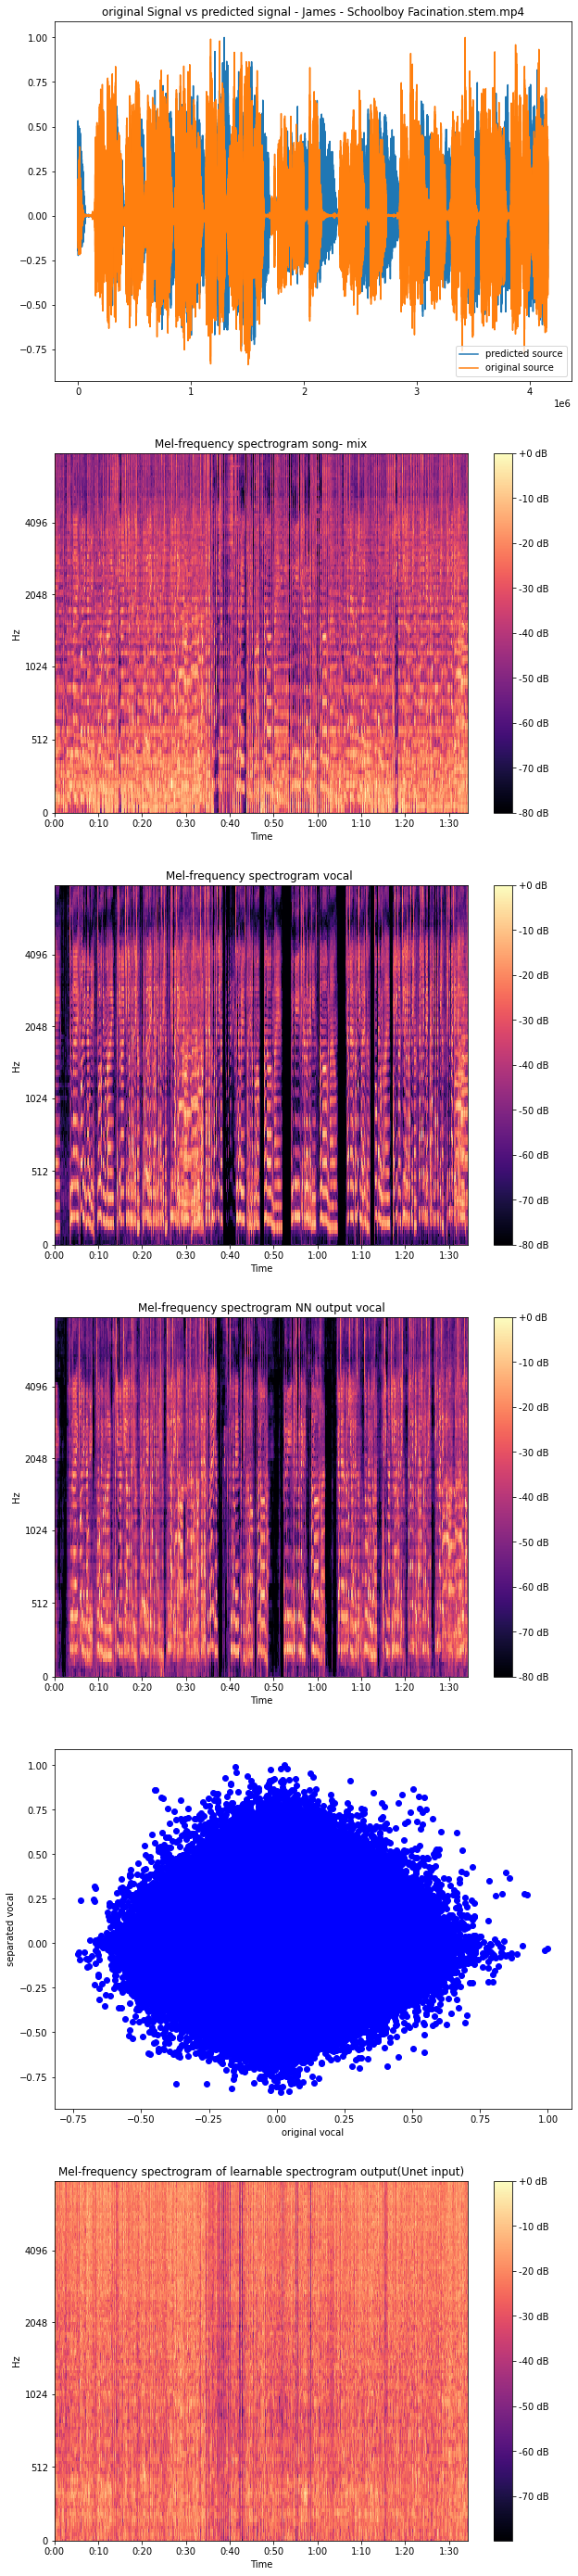

original mixture signal            =   (5292000,)
expected output signal data size   =   (5292000,)
dataset shape                      =   (2, 4, 16, 67072)
neural network separated data size =   torch.Size([4161536])
Contra - Heart Peripheral.stem.mp4
MSE =  0.03707905200845264
SISNR =  tensor([[0.7272]], dtype=torch.float64)
SDR =  0.0
STOI =  0.050641494010817925


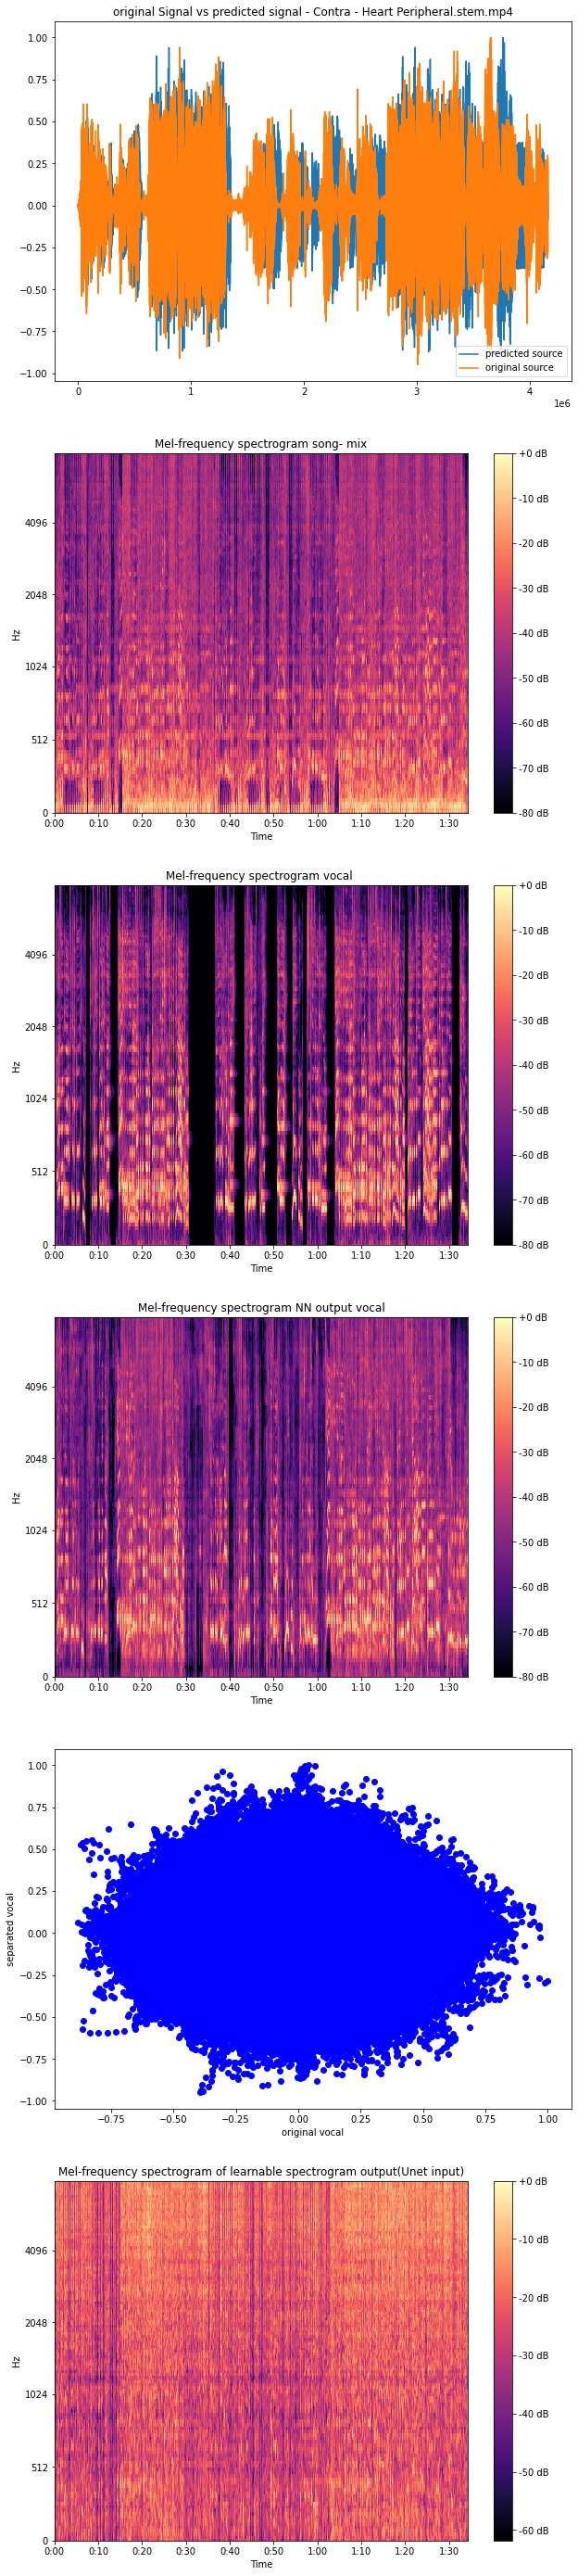

original mixture signal            =   (5292000,)
expected output signal data size   =   (5292000,)
dataset shape                      =   (2, 4, 16, 67072)
neural network separated data size =   torch.Size([4161536])
els In Amplifiers - I'm Alright.stem.mp4
MSE =  0.030108665090321125
SISNR =  tensor([[1.6881]], dtype=torch.float64)
SDR =  0.0
STOI =  0.07152394601131745


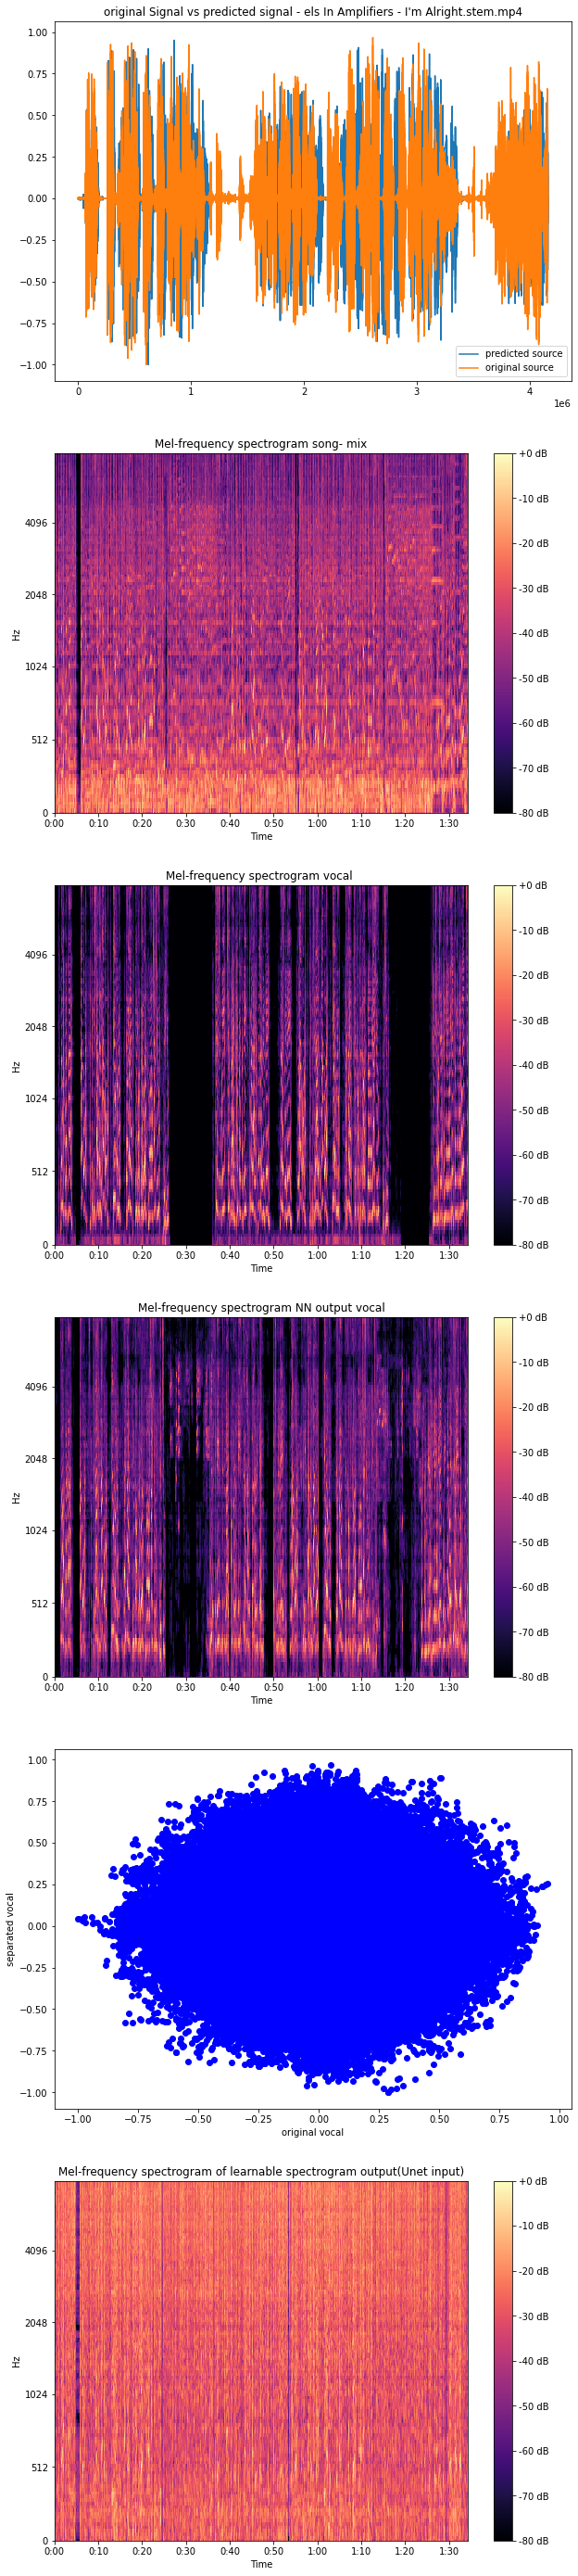

/usr/local/lib/python3.8/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '


original mixture signal            =   (5292000,)
expected output signal data size   =   (5292000,)
dataset shape                      =   (2, 4, 16, 67072)
neural network separated data size =   torch.Size([4161536])
se - Run Run Run.stem.mp4
MSE =  0.03693078220508204
SISNR =  tensor([[1.0329]], dtype=torch.float64)
SDR =  0.0
STOI =  0.08680389966690659


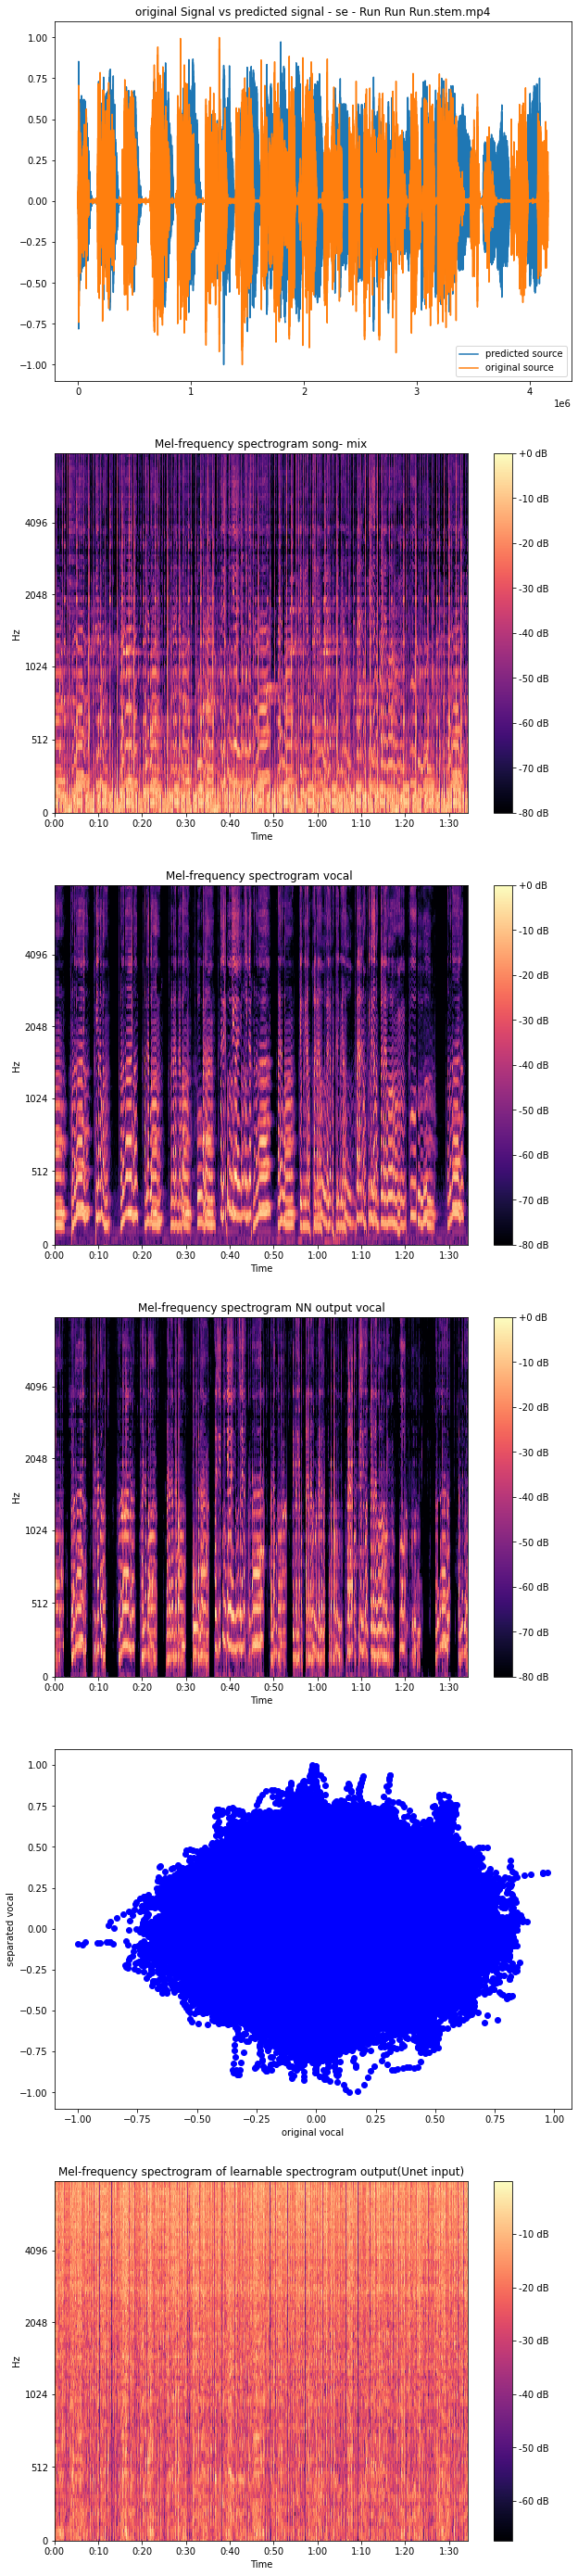

ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute training/batch/lossSISNR


original mixture signal            =   (5292000,)
expected output signal data size   =   (5292000,)
dataset shape                      =   (2, 4, 16, 67072)
neural network separated data size =   torch.Size([4161536])
 Carrigan - We'll Talk About It All Tonight.stem.mp4
MSE =  0.0183032978798657
SISNR =  tensor([[3.8983]], dtype=torch.float64)
SDR =  0.0
STOI =  0.10545911525989136


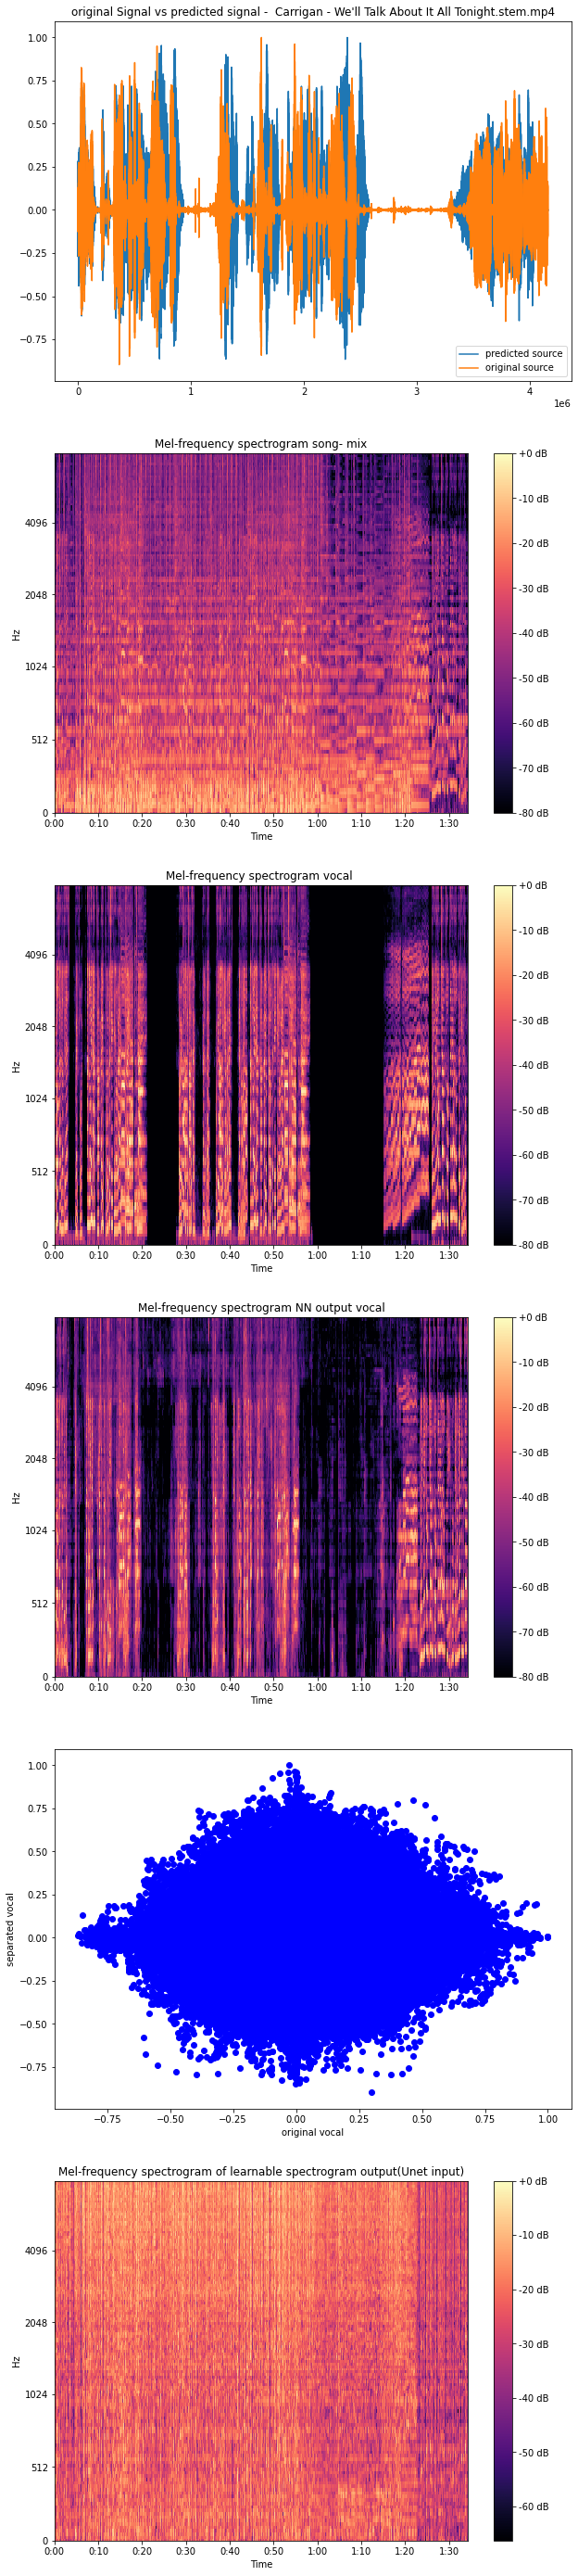

ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute training/batch/lossSISNR
/usr/local/lib/python3.8/dist-packages/pystoi/stoi.py:66: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  warnings.warn('Not enough STFT frames to compute intermediate '


original mixture signal            =   (5292000,)
expected output signal data size   =   (5292000,)
dataset shape                      =   (2, 4, 16, 67072)
neural network separated data size =   torch.Size([4161536])
 - Bulldozer.stem.mp4
MSE =  0.03166318309610044
SISNR =  tensor([[1.8335]], dtype=torch.float64)
SDR =  0.0
STOI =  0.042665495217793156


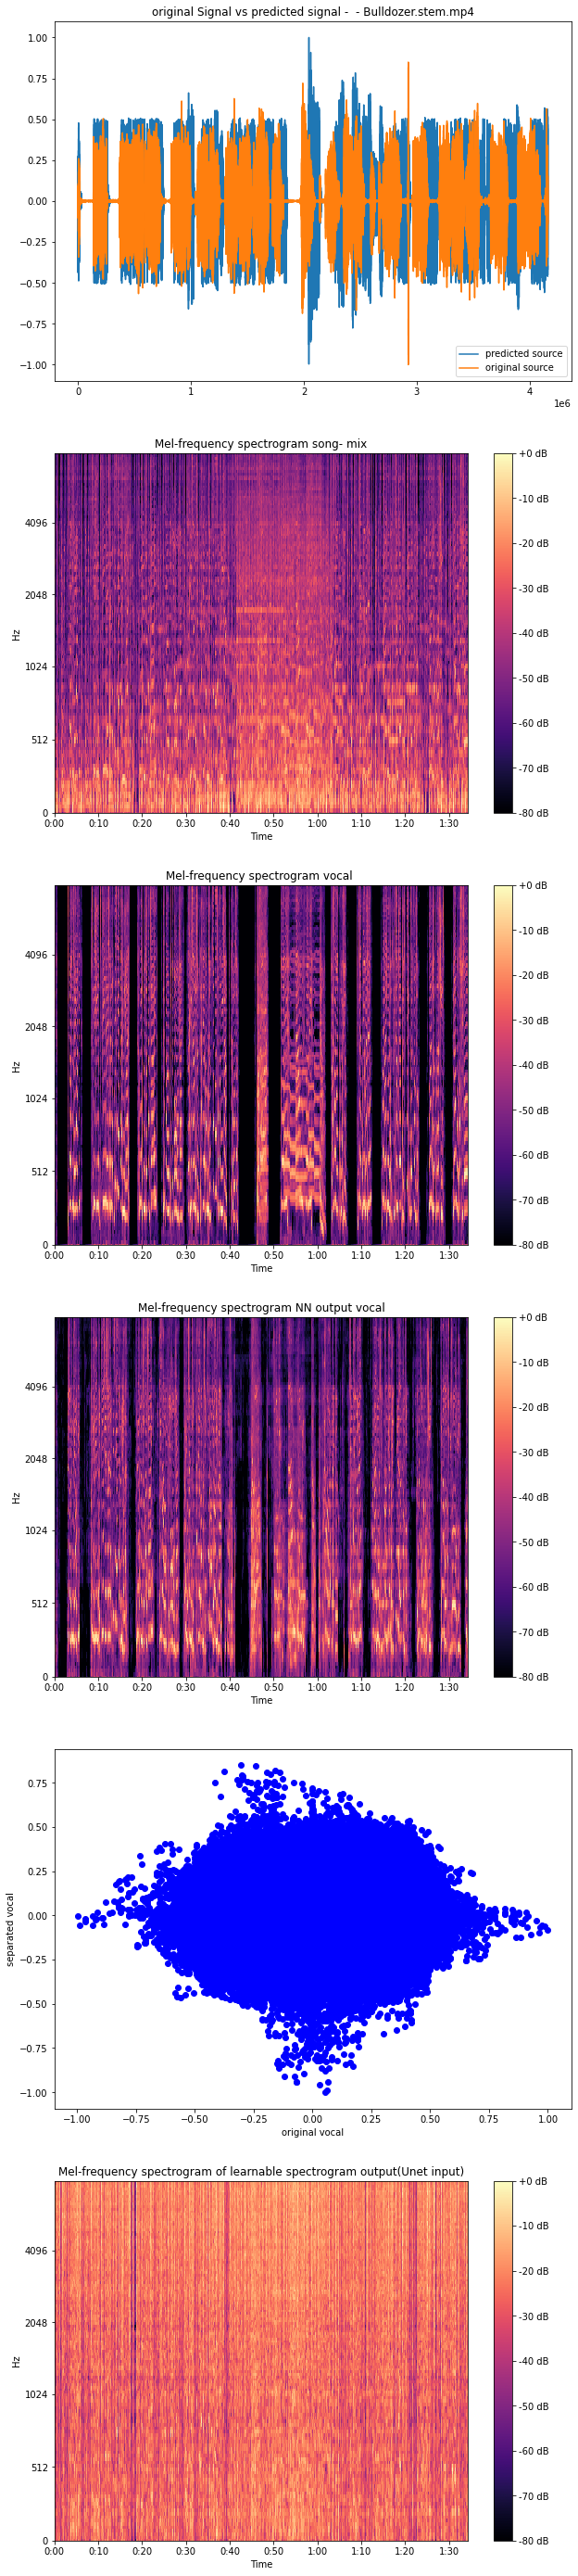

original mixture signal            =   (5292000,)
expected output signal data size   =   (5292000,)
dataset shape                      =   (2, 4, 16, 67072)
neural network separated data size =   torch.Size([4161536])
 - Too Much.stem.mp4
MSE =  0.036284176758627516
SISNR =  tensor([[nan]], dtype=torch.float64)
SDR =  0.0
STOI =  0.07827601528739113


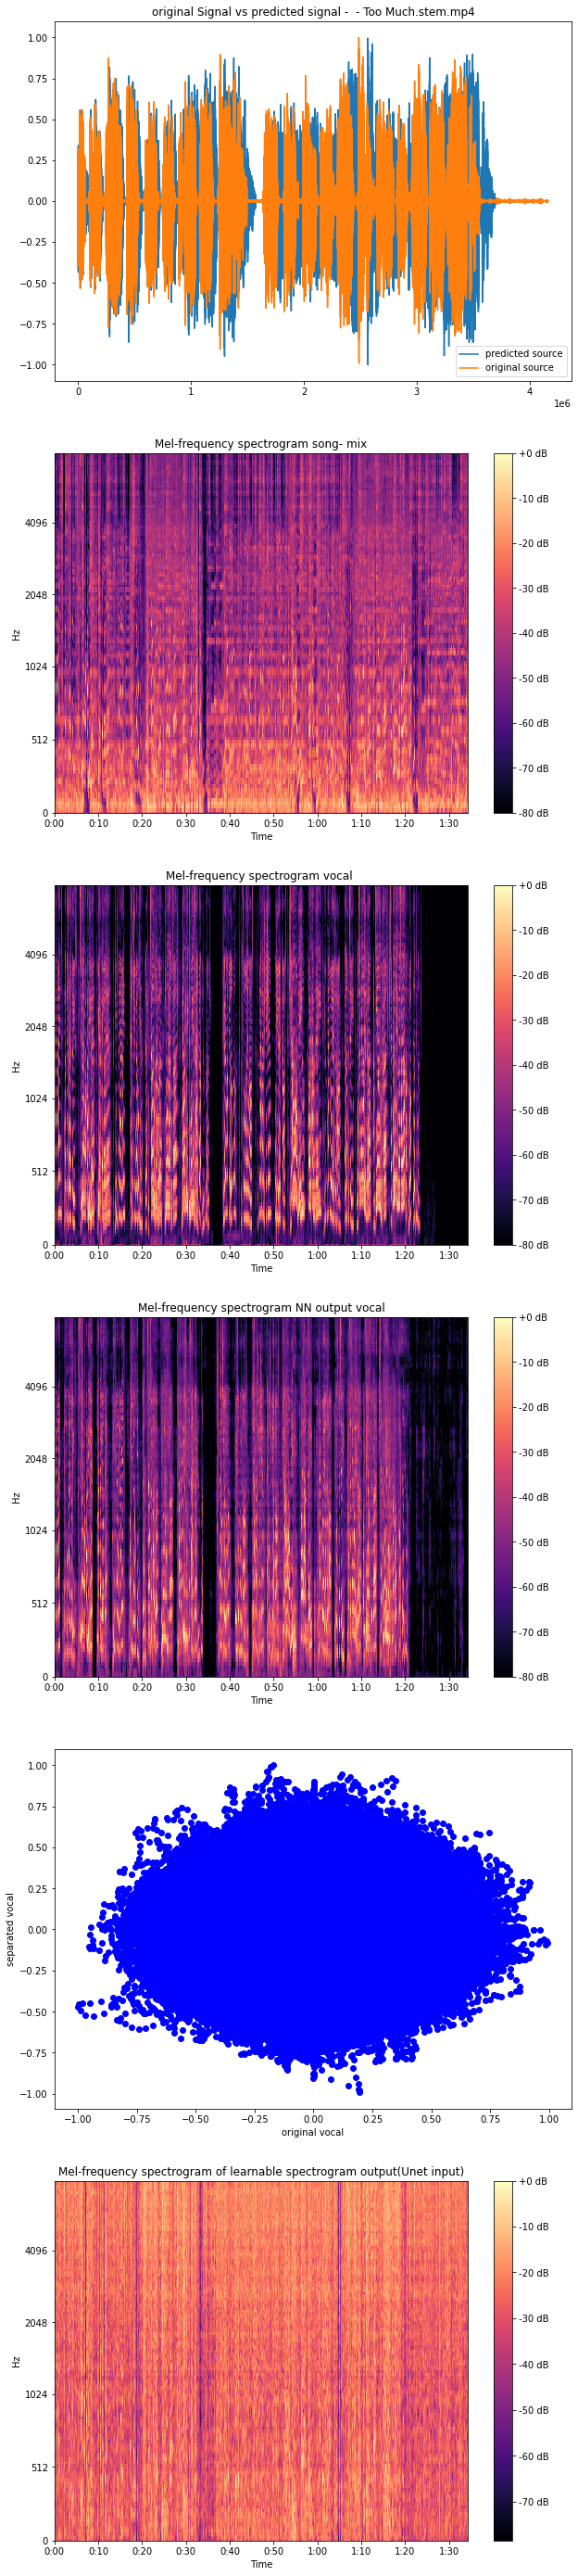

ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute training/batch/lossSISNR
ERROR:neptune.new.internal.operation_processors.async_operation_processor:Error occurred during asynchronous operation processing: Cannot log infinite or NaN value to attribute training/batch/lossSISNR


original mixture signal            =   (5292000,)
expected output signal data size   =   (5292000,)
dataset shape                      =   (2, 4, 16, 67072)
neural network separated data size =   torch.Size([4161536])
traker - Revo X.stem.mp4
MSE =  0.024328503731406735
SISNR =  tensor([[-1.3707]], dtype=torch.float64)
SDR =  0.0
STOI =  0.044579891864577316


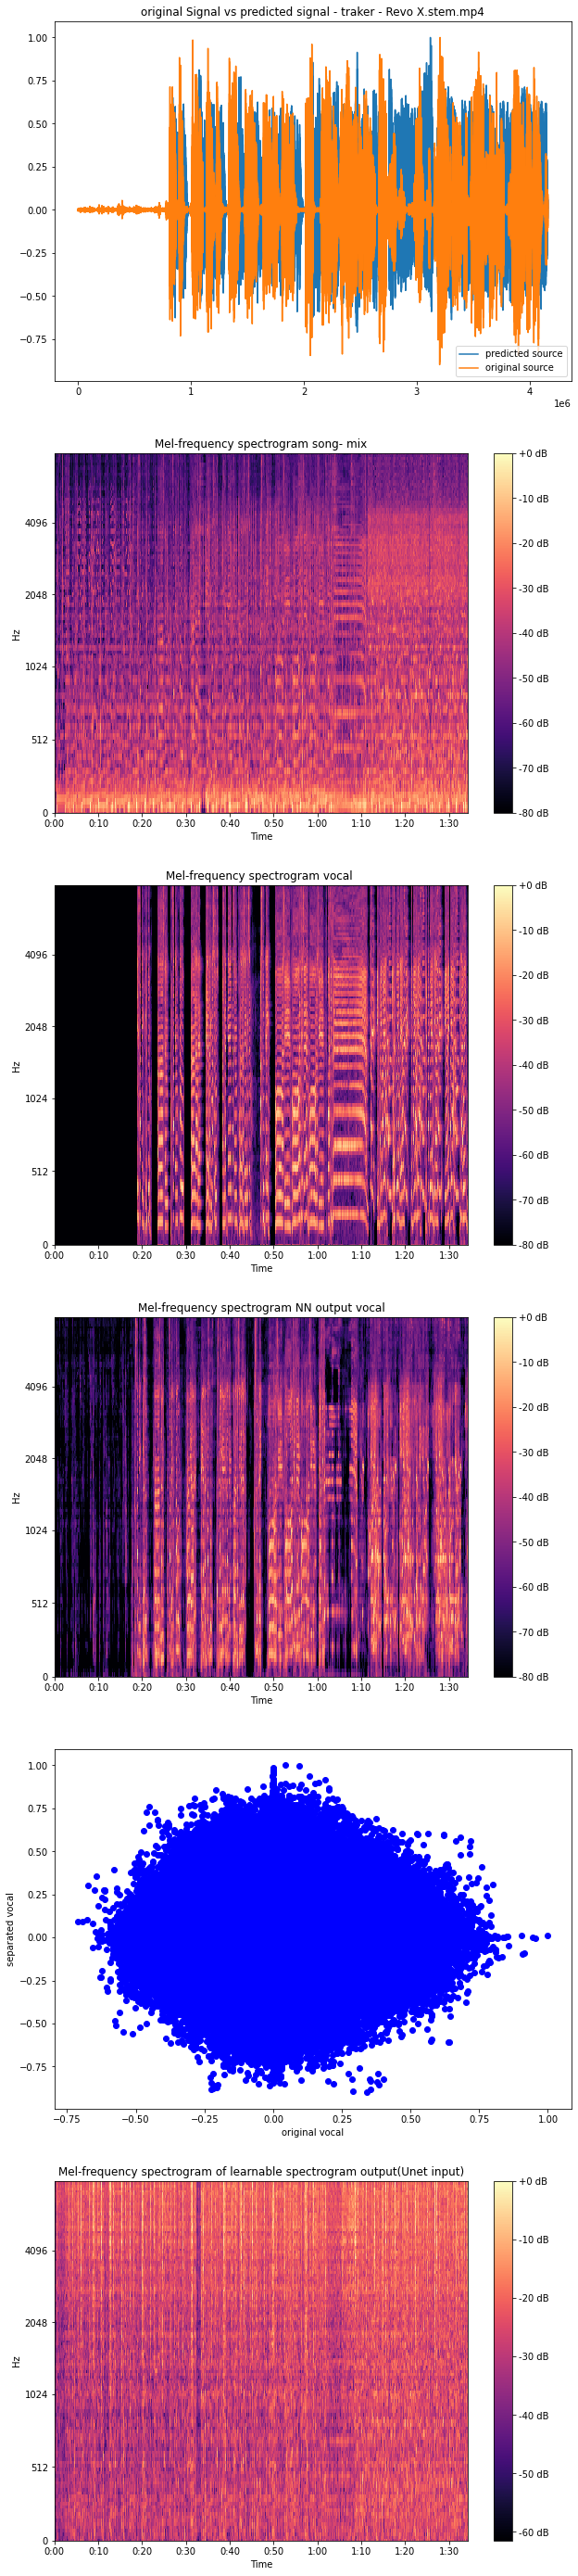

KeyboardInterrupt: ignored

In [ ]:
#@title Test data
from pystoi import stoi
import torchmetrics
from torchmetrics.audio import SignalDistortionRatio
import matplotlib as mpl
# from torchmetrics.audio import PermutationInvariantTraining
# from torchmetrics.functional.audio import signal_distortion_ratio
# from torchmetrics.functional.audio import signal_distortion_ratio
import mir_eval

loss_function = SISNR(time_length)
sdr = SignalDistortionRatio().to(device)
g = torch.manual_seed(1)
songlist =[]
model.eval()
directory = '/content/drive/Shareddrives/Full datasets/MUSDB18 Dataset/test'
# sdr = SignalDistortionRatio()
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # # checking if it is a file
    if os.path.isfile(f):

      songlist.append(f)
      # print(f)

for i in range(20):
  S, sr = stempeg.read_stems(songlist[i])
  ytest =  librosa.util.normalize(np.array(S[0][sr*30:sr*150,0])) #sr*10:sr*100
  vocal = librosa.util.normalize(np.array(S[4][sr*30:sr*150,0]))
  n_fft = 2046
  hop_length=512
  SNRloss = 0
  SDRn = 0
  test = make_dataset(ytest,vocal,0,batch_size,time_window_size,0)
  test_set,Complex_spectrum,Vocal,number_of_batches, batch_size,timedomainlength,freqdomainlength = spectro(torch.Tensor(test),n_fft,hop_length)

  mixS= torch.unsqueeze(test_set,3)
  Vocal = torch.unsqueeze(Vocal,3)
  test_set = torch.unsqueeze(torch.Tensor(test),3)

  out = torch.zeros(1).to(device)               #neural network is designed for batch size data chunks.So we got no option but to send data in [batch_size,time_window] size form. Once a time we send [batch_size,time_window] data chunk and concatanate it with an emptyy tensor.
  outInter = torch.zeros(1).to(device)
  for p in range(number_of_batches):

    z,l = model(test_set[0][p].to(device).float(),mixS[0][p].to(device).float())
    # z = model(test_set[0][p].to(device).float(),mixS[0][p].to(device).float())[0]
    # SNRloss = SNRloss + loss_function(l,Vocal[0][p].to(device).float()).detach().cpu()
    # SDRn = SDRn+sdr(torch.squeeze(l,1).detach().cpu()+0.00001, torch.squeeze(Vocal[0][p],1).detach().cpu()+0.00001)
    l = l.detach().cpu().numpy()
    z = z.detach().cpu().numpy()
    vc = Vocal[0][p].detach().cpu().numpy()
    # vc = test_set[1][p].detach().cpu().numpy()
    for k in range(batch_size):
      rInter = z[k][0]*(np.cos(Complex_spectrum[p][k])+np.sin(Complex_spectrum[p][k])*1j)
      adInter = librosa.istft(rInter.T,  hop_length=hop_length,win_length = n_fft)#,center=True,dtype='complex_',length=time_window_size)
      outInter = torch.cat(  (outInter, torch.Tensor(adInter).to(device)   ) , 0 )

      r = l[k][0]*(np.cos(Complex_spectrum[p][k])+np.sin(Complex_spectrum[p][k])*1j)
      ad = librosa.istft(r.T,  hop_length=hop_length,win_length = n_fft)#,center=True,dtype='complex_',length=time_window_size)
      out = torch.cat(  (out, torch.Tensor(ad).to(device)   ) , 0 )

      truevoc = vc[k][0]*(np.cos(Complex_spectrum[p][k])+np.sin(Complex_spectrum[p][k])*1j)
      truevoc = librosa.istft(truevoc.T,  hop_length=hop_length,win_length = n_fft)
      # SDRn, _, _, _ = mir_eval.separation.bss_eval_sources(l.detach().cpu().numpy(), Vocal[0][p].detach().cpu().numpy())
      n = min(len(truevoc),len(ad))
      loss_function = SISNR(n)
      SDRloss = sdr(torch.tensor(ad[0:n].astype(float))+0.0001,torch.tensor(truevoc[0:n].astype(float))+0.0001)
      STOIloss = stoi(torch.tensor(ad[0:n].astype(float)),torch.tensor(truevoc[0:n].astype(float)),sr)
      SNRloss = loss_function(torch.tensor(ad[0:n].astype(float)),torch.tensor(truevoc[0:n].astype(float)))
      run[f"training/batch/lossSISNR"].log(SNRloss)
      run[f"training/batch/lossSDR"].log(SDRloss)
      run[f"training/batch/lossSTOI"].log(STOIloss)
      # print(r.shape)
      # print(out.shape)

  #input vocal is larger than output audio because in the makedataset function it truncates a part of input to otain the correct shapes with atch sizes
  print("original mixture signal            =  ", ytest.shape)
  print("expected output signal data size   =  ",vocal.shape)
  print("dataset shape                      =  ",test.shape)
  print("neural network separated data size =  ",out[1:].shape)         #we added an empty zero tensor before.to get rid of it we use [1 :]

  out = out.view(-1)
  aud = out.detach().cpu().numpy()
  aud = librosa.util.normalize(aud)

  outInter = outInter.view(-1)
  audInter = outInter.detach().cpu().numpy()
  audInter = librosa.util.normalize(audInter)

  # ytest = ytest[0:number_of_batches*batch_size*time_window_size]
  sf.write('separated_song.wav',aud, sr)
  sf.write('mix_song.wav',ytest, sr)
  sf.write('intermediate.wav',audInter, sr)

  songname = songlist[i][66:]
  print(songname)

  run[f"audio/{songname}/separated song"].upload("/content/separated_song.wav")
  run[f"audio/{songname}/mixture file"].upload("/content/mix_song.wav")
  run[f"audio/{songname}/intermediate file"].upload("/content/intermediate.wav")

  n = min(len(vocal),len(aud))
  ytest = ytest[0:n]
  vocal = vocal[0:n]

  mse = ((vocal[0:n] - aud[0:n])**2).mean(axis=0)
  print("MSE = ",mse)

  # loss_function = SISNR(n)
  # loss = loss_function(torch.tensor(aud[0:n].astype(float)),torch.tensor(vocal[0:n].astype(float)))
  # SDRloss = signal_distortion_ratio(torch.tensor(aud[0:n].astype(float)),torch.tensor(vocal[0:n].astype(float)))
  STOIloss = stoi(torch.tensor(aud[0:n].astype(float)),torch.tensor(vocal[0:n].astype(float)),sr)
  loss = (SNRloss/number_of_batches)
  SDRloss = SDRn/number_of_batches
  print("SISNR = ", loss)
  print("SDR = ", SDRloss)
  print("STOI = ", STOIloss)
  run[f"test files/lossMSE"].log(mse)

  # run[f"training/batch/lossSISNR"].log(loss)

  # run[f"training/batch/lossSDR"].log(SDRloss)
  # run[f"training/batch/lossSTOI"].log(STOIloss)


  fig = plt.figure()
  fig.set_figwidth(10)
  fig.set_figheight(50)

  ax1 = fig.add_subplot(6,1,1)
  plt.title(f"original Signal vs predicted signal - {songname}")
  ax1.plot(vocal)
  ax1.plot(aud)
  plt.legend(["predicted source", "original source"], loc ="lower right")


  S = librosa.feature.melspectrogram(y=ytest, sr=sr, n_mels=128,
                                      fmax=8000)
  ax2 = fig.add_subplot(6,1,2)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000, ax=ax2)
  fig.colorbar(img, ax=ax2, format='%+2.0f dB')
  ax2.set(title='Mel-frequency spectrogram song- mix')



  S = librosa.feature.melspectrogram(y=vocal, sr=sr, n_mels=128,
                                      fmax=8000)
  im1 = S
  ax3 = fig.add_subplot(6,1,3)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000, ax=ax3)
  fig.colorbar(img, ax=ax3, format='%+2.0f dB')
  ax3.set(title='Mel-frequency spectrogram vocal ')



  S = librosa.feature.melspectrogram(y=aud, sr=sr, n_mels=128,
                                      fmax=8000)

  im2 = S
  ax4 = fig.add_subplot(6,1,4)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000, ax=ax4)
  fig.colorbar(img, ax=ax4, format='%+2.0f dB')
  ax4.set(title='Mel-frequency spectrogram NN output vocal')

  ax5 = fig.add_subplot(6,1,5)
  p = min(len(vocal),len(aud))
  ax5.scatter(vocal[0:p],aud[0:p], c ="blue")
  plt.xlabel("original vocal")
  plt.ylabel("separated vocal")


  S = librosa.feature.melspectrogram(y=audInter, sr=sr, n_mels=128,
                                      fmax=8000)


  ax6 = fig.add_subplot(6,1,6)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000, ax=ax6)
  fig.colorbar(img, ax=ax6, format='%+2.0f dB')
  ax6.set(title='Mel-frequency spectrogram of learnable spectrogram output(Unet input)')

  plt.show()

  run["images/predictions"].log( File.as_image(fig))
  # mpl.rcParams['agg.path.chunksize'] = 1000
  # fig.savefig("/content/drive/MyDrive/Y net paper/images/new/test.png",dpi=300)
  # cor = signal.correlate2d(im1, im2)
  # print(cor)
  # run[f"test files/2DCorrelation-{songname}"].log(cor)




In [ ]:
 truevoc.shape

(128, 1024)

In [ ]:
#@title Test data
from pystoi import stoi
import torchmetrics
from torchmetrics.audio import SignalDistortionRatio
# from torchmetrics.audio import PermutationInvariantTraining
# from torchmetrics.functional.audio import signal_distortion_ratio
# from torchmetrics.functional.audio import signal_distortion_ratio
import mir_eval

loss_function = SISNR(time_length)
sdr = SignalDistortionRatio().to(device)
g = torch.manual_seed(1)
songlist =[]
model.eval()
directory = '/content/drive/Shareddrives/Full datasets/MUSDB18 Dataset/test'
# sdr = SignalDistortionRatio()
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # # checking if it is a file
    if os.path.isfile(f):

      songlist.append(f)
      # print(f)

for i in range(20):
  S, sr = stempeg.read_stems(songlist[i])
  ytest =  librosa.util.normalize(np.array(S[0][sr*30:sr*150,0])) #sr*10:sr*100
  vocal = librosa.util.normalize(np.array(S[4][sr*30:sr*150,0]))
  n_fft = 2046
  hop_length=512
  SNRloss = 0
  SDRn = 0
  test = make_dataset(ytest,vocal,0,batch_size,time_window_size,0)
  test_set,Complex_spectrum,Vocal,number_of_batches, batch_size,timedomainlength,freqdomainlength = spectro(torch.Tensor(test),n_fft,hop_length)

  mixS= torch.unsqueeze(test_set,3)
  Vocal = torch.unsqueeze(Vocal,3)
  test_set = torch.unsqueeze(torch.Tensor(test),3)

  out = torch.zeros(1).to(device)               #neural network is designed for batch size data chunks.So we got no option but to send data in [batch_size,time_window] size form. Once a time we send [batch_size,time_window] data chunk and concatanate it with an emptyy tensor.
  outInter = torch.zeros(1).to(device)
  for p in range(number_of_batches):

    z,l = model(test_set[0][p].to(device).float(),mixS[0][p].to(device).float())
    # z = model(test_set[0][p].to(device).float(),mixS[0][p].to(device).float())[0]
    SNRloss = SNRloss + loss_function(l,Vocal[0][p].to(device).float()).detach().cpu()
    # pit = PermutationInvariantTraining(signal_distortion_ratio, 'max')

    SDRn = SDRn+sdr(torch.squeeze(l,1).detach().cpu()+0.00001, torch.squeeze(Vocal[0][p],1).detach().cpu()+0.00001)
    STOIloss = stoi(torch.tensor(aud[0:n].astype(float)),torch.tensor(vocal[0:n].astype(float)),sr)
    l = l.detach().cpu().numpy()
    z = z.detach().cpu().numpy()

    for k in range(batch_size):
      rInter = z[k][0]*(np.cos(Complex_spectrum[p][k])+np.sin(Complex_spectrum[p][k])*1j)
      adInter = librosa.istft(rInter.T,  hop_length=hop_length,win_length = n_fft)#,center=True,dtype='complex_',length=time_window_size)
      outInter = torch.cat(  (outInter, torch.Tensor(adInter).to(device)   ) , 0 )

      r = l[k][0]*(np.cos(Complex_spectrum[p][k])+np.sin(Complex_spectrum[p][k])*1j)
      ad = librosa.istft(r.T,  hop_length=hop_length,win_length = n_fft)#,center=True,dtype='complex_',length=time_window_size)
      out = torch.cat(  (out, torch.Tensor(ad).to(device)   ) , 0 )
      # SDRn, _, _, _ = mir_eval.separation.bss_eval_sources(l.detach().cpu().numpy(), Vocal[0][p].detach().cpu().numpy())

      # print(r.shape)
      # print(out.shape)

  #input vocal is larger than output audio because in the makedataset function it truncates a part of input to otain the correct shapes with atch sizes
  print("original mixture signal            =  ", ytest.shape)
  print("expected output signal data size   =  ",vocal.shape)
  print("dataset shape                      =  ",test.shape)
  print("neural network separated data size =  ",out[1:].shape)         #we added an empty zero tensor before.to get rid of it we use [1 :]

  out = out.view(-1)
  aud = out.detach().cpu().numpy()
  aud = librosa.util.normalize(aud)

  outInter = outInter.view(-1)
  audInter = outInter.detach().cpu().numpy()
  audInter = librosa.util.normalize(audInter)

  # ytest = ytest[0:number_of_batches*batch_size*time_window_size]
  sf.write('separated_song.wav',aud, sr)
  sf.write('mix_song.wav',ytest, sr)
  sf.write('intermediate.wav',audInter, sr)

  songname = songlist[i][66:]
  print(songname)

  run[f"audio/{songname}/separated song"].upload("/content/separated_song.wav")
  run[f"audio/{songname}/mixture file"].upload("/content/mix_song.wav")
  run[f"audio/{songname}/intermediate file"].upload("/content/intermediate.wav")

  n = min(len(vocal),len(aud))
  ytest = ytest[0:n]
  vocal = vocal[0:n]

  mse = ((vocal[0:n] - aud[0:n])**2).mean(axis=0)
  print("MSE = ",mse)

  # loss_function = SISNR(n)
  # loss = loss_function(torch.tensor(aud[0:n].astype(float)),torch.tensor(vocal[0:n].astype(float)))
  # SDRloss = signal_distortion_ratio(torch.tensor(aud[0:n].astype(float)),torch.tensor(vocal[0:n].astype(float)))
  STOIloss = stoi(torch.tensor(aud[0:n].astype(float)),torch.tensor(vocal[0:n].astype(float)),sr)
  loss = (SNRloss/number_of_batches)
  SDRloss = SDRn/number_of_batches
  print("SISNR = ", loss)
  print("SDR = ", SDRloss)
  print("STOI = ", STOIloss)
  run[f"test files/lossMSE"].log(mse)

  run[f"training/batch/lossSISNR"].log(loss)

  run[f"training/batch/lossSDR"].log(SDRloss)
  run[f"training/batch/lossSTOI"].log(STOIloss)


  fig = plt.figure()
  fig.set_figwidth(10)
  fig.set_figheight(50)

  ax1 = fig.add_subplot(6,1,1)
  plt.title(f"original Signal vs predicted signal - {songname}")
  ax1.plot(vocal)
  ax1.plot(aud)
  plt.legend(["predicted source", "original source"], loc ="lower right")


  S = librosa.feature.melspectrogram(y=ytest, sr=sr, n_mels=128,
                                      fmax=8000)
  ax2 = fig.add_subplot(6,1,2)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000, ax=ax2)
  fig.colorbar(img, ax=ax2, format='%+2.0f dB')
  ax2.set(title='Mel-frequency spectrogram song- mix')



  S = librosa.feature.melspectrogram(y=vocal, sr=sr, n_mels=128,
                                      fmax=8000)
  im1 = S
  ax3 = fig.add_subplot(6,1,3)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000, ax=ax3)
  fig.colorbar(img, ax=ax3, format='%+2.0f dB')
  ax3.set(title='Mel-frequency spectrogram vocal ')



  S = librosa.feature.melspectrogram(y=aud, sr=sr, n_mels=128,
                                      fmax=8000)

  im2 = S
  ax4 = fig.add_subplot(6,1,4)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000, ax=ax4)
  fig.colorbar(img, ax=ax4, format='%+2.0f dB')
  ax4.set(title='Mel-frequency spectrogram NN output vocal')

  ax5 = fig.add_subplot(6,1,5)
  p = min(len(vocal),len(aud))
  ax5.scatter(vocal[0:p],aud[0:p], c ="blue")
  plt.xlabel("original vocal")
  plt.ylabel("separated vocal")


  S = librosa.feature.melspectrogram(y=audInter, sr=sr, n_mels=128,
                                      fmax=8000)


  ax6 = fig.add_subplot(6,1,6)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000, ax=ax6)
  fig.colorbar(img, ax=ax6, format='%+2.0f dB')
  ax6.set(title='Mel-frequency spectrogram of learnable spectrogram output(Unet input)')

  plt.show()

  run["images/predictions"].log( File.as_image(fig))
  # cor = signal.correlate2d(im1, im2)
  # print(cor)
  # run[f"test files/2DCorrelation-{songname}"].log(cor)



In [ ]:
from torchmetrics.audio import SignalDistortionRatio
import torch
g = torch.manual_seed(1)
preds = torch.randn(16, 128, 1024)  # [batch, spk, time]
target = torch.randn(16, 128, 1024)
print(preds.shape,target.shape)
sdr = SignalDistortionRatio()
sdr(preds, target)


torch.Size([16, 128, 1024]) torch.Size([16, 128, 1024])


tensor(-2.3862)

In [ ]:
from torchmetrics.audio import PermutationInvariantTraining
from torchmetrics.functional.audio import signal_distortion_ratio
preds = torch.randn(16, 128, 1024)  # [batch, spk, time]
target = torch.randn(16, 128, 1024)
# preds = torch.squeeze(l,1).detach().cpu()
# target = torch.squeeze(Vocal[0][p],1).detach().cpu()
print(preds.shape,target.shape)
pit = PermutationInvariantTraining(signal_distortion_ratio, 'max')
pit(preds, target)

In [ ]:
from torchmetrics.functional.audio.stoi import short_time_objective_intelligibility
import torch
from pystoi import stoi
g = torch.manual_seed(1)
preds = torch.randn(16, 128, 1024)  # [batch, spk, time]
target = torch.randn(16, 128, 1024)
loss_func = stoi(preds,target,1024)
print(loss_func)

In [ ]:
run.stop()
# # cor = signal.correlate2d(im1,im2)
# # print(cor)
# (np.cos(Complex_spectrum[p][k])+np.sin(Complex_spectrum[p][k])*1j).shape
# l[k].shape

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/e16103/Ynet/e/YNET-45


In [ ]:
print(Complex_spectrum)

In [ ]:
# songlist =[]

# directory = '/content/drive/Shareddrives/G-33-2022/Audios/MUSDB18 Dataset/test'
# for filename in os.listdir(directory):
#     f = os.path.join(directory, filename)
#     # # checking if it is a file
#     if os.path.isfile(f):

#       songlist.append(f)
#       # print(f)

# i=1
# S, sr = stempeg.read_stems(songlist[i])
# ytest =  librosa.util.normalize(np.array(S[0][sr*10:sr*100,0]))
# vocal = librosa.util.normalize(np.array(S[4][sr*10:sr*100,0]))
# n_fft = 2046
# hop_length=512


# test = make_dataset(ytest,vocal,0,batch_size,time_window_size,0)
# test_set,Vocal_Data_Set,number_of_batches, batch_size,timedomainlength,freqdomainlength = spectro(torch.Tensor(test),n_fft,hop_length)

# test_set = torch.unsqueeze(test_set,3)

# out = torch.zeros(1).to(device)               #neural network is designed for batch size data chunks.So we got no option but to send data in [batch_size,time_window] size form. Once a time we send [batch_size,time_window] data chunk and concatanate it with an emptyy tensor.

# for i in range(number_of_batches):
#   l  = model(test_set[0][i].to(device).float()).detach().cpu().numpy()
#   for j in range(batch_size):
#     r = l[j][0]*Vocal_Data_Set[i][j]
#     ad = librosa.istft(r.T,  hop_length=hop_length,win_length = n_fft,center=False,length=time_window_size)
#     out = torch.cat(  (out, torch.Tensor(ad).to(device)   ) , 0 )
#     print(r.shape)
#     print(out.shape)

# #input vocal is larger than output audio because in the makedataset function it truncates a part of input to otain the correct shapes with atch sizes

In [ ]:
# print(vocal.shape)
# print(out.shape)
# print(ad.shape)
# print(out.shape[0]-vocal.shape[0])
out1[0].shape

In [ ]:
fig = plt.figure()
S  =   out1[0][0].detach().cpu().numpy()#-ground_truth[50][7][0]
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=44100,
                          fmax=8000)
fig.colorbar(img, format='%+2.0f dB')
plt.show()

In [ ]:
fig = plt.figure()
S  =   (out2[0][0]).detach().cpu().numpy()#-ground_truth[50][7][0]
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=44100,
                          fmax=8000)
fig.colorbar(img, format='%+2.0f dB')
plt.show()